# Baseline Code

This code introduces a two-step training for the N-HPatches problem. In N-HPatches problem, we aim to generate a patch descriptor that is able to perform successfully tasks such as matching, retrieval or verification. 

Contrary to classical HPatches dataset, in N-HPatches, images contain random non-smooth perturbations produced by a synthetic noise. This noise could be critical when training the descriptor, therefore, we introduce a denoising model that could help us to deal with those perturbations. Denoising models have been already introduced in the course [tutorials](https://github.com/MatchLab-Imperial/deep-learning-course) and lectures, their objective is to generate a clean/denoised version of the input image.  We will refer in this code to the images with noise as `noisy`, to the images after applying the denoise model as `denoised` and the original patches from HPatches (so no extra noise added) which are used as ground-truth for the denoising step as `clean`. 


Thus, we aim to minimize the noise in images before the second step, which is computing a feature vector, also called descriptor. Those descriptions must be a powerful representation of the input patches. The idea behind is that if two descriptors belong two similar patches, they should be close to each other, i.e. have a low Euclidean distance. See figure below:

![](https://i.ibb.co/4tvm3Vh/descriptorspace.png)

This baseline code gives a method you can use to compare to whatever another approach you develop.  There are several other approaches you can test to see if there is any improvement, e.g. train the descriptor directly with noisy patches, without the denoising model. However, this code provides some guidance about how to implement the different blocks, how to stack them if desired, how to read the data and how to evaluate the method.

The values given can be improved without changing the core method, only by tuning correctly the hyperparameters or giving it more training time, among others.

As a first step of the project, you should get familiar with the problem and the provided code, so you can develop more complex and robust algorithms afterward. 

## Safety Check

As Google Colab is an external platform, we cannot guarantee that everytime you connect to a remote server, you will have the same amount of RAM or video RAM. For that reason, we will first check the amount of memory we have in the notebook. RAM should be around 12.9 GB, which is enough to load the datasets in memory. Also, usually, we have available 11.4 GB of GPU memory, which is more than enough to run this code. However, some users reported having only 500 MB of GPU memory. If you have that amount, restart the environment to see if you get the corresponding 11.4 GB.

In [1]:
# Taken from
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
#!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
#!pip install gputil
#!pip install psutil
#!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# Colab only provides one GPU and it is not always guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

In [2]:
printm()

RAM Free: 28.4 GB  | Proc size: 50.7 MB
GPU RAM Free: 10836MB | Used: 428MB | Util   4% | Total 11264MB


## Downloading Functions and Data

The first step is to clone the GitHub repository of the course, which contains already implemented functions. You can use your own function and import them here doing the same. In addition, we are going to download and extract the N-HPatches data. 

As a note, in colab, we can run terminal commands by using ```!```. Also, by using ```%``` we have access to the [built-in IPython magic commands](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-cd), which we will use to move through directories (`cd` command). It takes around 5 minutes to download and unzip the dataset. 


In [ ]:
# Clone repo
!git clone https://github.com/MatchLab-Imperial/keras_triplet_descriptor

In [3]:
# Change directory
%cd keras_triplet_descriptor    


C:\Users\User\Downloads\keras_triplet_descriptor


In [ ]:
# Download data
!wget -O hpatches_data.zip https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip


In [ ]:
# Extract data
!unzip -q ./hpatches_data.zip
!rm ./hpatches_data.zip

## Importing Necessary Modules

We now import the modules we will use in this baseline code. 

In [4]:
import sys
import json
import os
import glob
import time
import tensorflow as tf
import numpy as np
import cv2
import random

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose
from keras.layers import Input, UpSampling2D, concatenate  

from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet

Using TensorFlow backend.


The `read_data` and `utils` imports are functions provided in the repository we just cloned. You can navigate through the *File tab* and check what those functions do for a better understanding.

![texto del enlace](https://i.ibb.co/HnfSvfT/filetab.png)





We also fix the seeds of the pseudo-random number generators to have reproducible results. The idea of fixing the seed is having the same results every time the algorithm is run if there are no changes in the code.

In [5]:
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

Now we load the data. The original HPatches dataset has several splits, which are used to separate the available sequences in train sequences and test sequences. For our experiments in N-HPatches we use the same splits as in HPatches. Specifically, we load (and report results) using the split `'a'`:


In [6]:
hpatches_dir = './hpatches'
splits_path = 'splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   

In [7]:
seqs

['C:\\Users\\User\\Downloads\\keras_triplet_descriptor\\hpatches\\i_ajuntament',
 'C:\\Users\\User\\Downloads\\keras_triplet_descriptor\\hpatches\\i_autannes',
 'C:\\Users\\User\\Downloads\\keras_triplet_descriptor\\hpatches\\i_bologna',
 'C:\\Users\\User\\Downloads\\keras_triplet_descriptor\\hpatches\\i_books',
 'C:\\Users\\User\\Downloads\\keras_triplet_descriptor\\hpatches\\i_boutique',
 'C:\\Users\\User\\Downloads\\keras_triplet_descriptor\\hpatches\\i_bridger',
 'C:\\Users\\User\\Downloads\\keras_triplet_descriptor\\hpatches\\i_brooklyn',
 'C:\\Users\\User\\Downloads\\keras_triplet_descriptor\\hpatches\\i_castle',
 'C:\\Users\\User\\Downloads\\keras_triplet_descriptor\\hpatches\\i_chestnuts',
 'C:\\Users\\User\\Downloads\\keras_triplet_descriptor\\hpatches\\i_contruction',
 'C:\\Users\\User\\Downloads\\keras_triplet_descriptor\\hpatches\\i_crownday',
 'C:\\Users\\User\\Downloads\\keras_triplet_descriptor\\hpatches\\i_crownnight',
 'C:\\Users\\User\\Downloads\\keras_triplet_descrip

In [8]:
seqs_train = list(filter(lambda x: x.split('\\')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('\\')[-1] in split['test'], seqs)) 

In [9]:
len(seqs)

116

In [10]:
len(seqs_train)

76

In [11]:
len(seqs_test)

40

## Models and loss

We now define three functions that define the main modules of our baseline. 

*   **get_denoise_model(..)** returns the denoising model. The input for the function is the size of the patch, which will be *1x32x32*, and it outputs a keras denoising model. 
*   **get_descriptor_model(..)** builts the descriptor model. The input for the function is the size of the patch, which will be *1x32x32*, and it outputs a keras descriptor model. The model we use as baseline returns a descriptor of dimension *128x1*.
*   **triplet_loss(..)** defines the loss function which is used to train the descriptor model. 

You can modify the models in these functions and run the training code again. For example, the given denoising model is quite shallow, maybe using a deeper network can improve results. Or testing new initializations for the weights. Or maybe adding dropout. Or modifying the loss function somehow...

In [12]:
def get_denoise_model(shape, do=0):
  
    inputs = Input(shape)
    
    conv1 = Dropout(do)((Conv2D(32, (3, 3), activation = 'relu', padding='same')(inputs)))
    conv1 = Dropout(do)((Conv2D(32, (3, 3), activation = 'relu', padding='same')(conv1)))
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Dropout(do)((Conv2D(64, (3, 3), activation = 'relu', padding='same')(pool1)))
    conv2 = Dropout(do)((Conv2D(64, (3, 3), activation = 'relu', padding='same')(conv2)))
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Dropout(do)((Conv2D(128, (3, 3), activation = 'relu', padding='same')(pool2)))
    conv3 = Dropout(do)((Conv2D(128, (3, 3), activation = 'relu', padding='same')(conv3)))
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Dropout(do)((Conv2D(256, (3, 3), activation = 'relu', padding='same')(pool3)))
    conv4 = Dropout(do)((Conv2D(256, (3, 3), activation = 'relu', padding='same')(conv4)))
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Dropout(do)((Conv2D(512, (3, 3), activation = 'relu', padding='same')(pool4)))
    conv5 = Dropout(do)((Conv2D(512, (3, 3), activation = 'relu', padding='same')(conv5)))

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Dropout(do)((Conv2D(256, (3, 3), activation = 'relu', padding='same')(up6)))
    conv6 = Dropout(do)((Conv2D(256, (3, 3), activation = 'relu', padding='same')(conv6)))

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Dropout(do)((Conv2D(128, (3, 3), activation = 'relu', padding='same')(up7)))
    conv7 = Dropout(do)((Conv2D(128, (3, 3), activation = 'relu', padding='same')(conv7)))

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Dropout(do)((Conv2D(64, (3, 3), activation = 'relu', padding='same')(up8)))
    conv8 = Dropout(do)((Conv2D(64, (3, 3), activation = 'relu', padding='same')(conv8)))

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Dropout(do)((Conv2D(32, (3, 3), activation = 'relu', padding='same')(up9)))
    conv9 = Dropout(do)((Conv2D(32, (3, 3), activation = 'relu', padding='same')(conv9)))

    conv10 = Dropout(do)(Conv2D(1, (1, 1))(conv9))

    model = Model(inputs=[inputs], outputs=[conv10])

    return model


def get_descriptor_model(shape):
  
    '''Architecture copies HardNet architecture'''

    init_weights = keras.initializers.he_normal()

    descriptor_model = Sequential()
    descriptor_model.add(Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))

    descriptor_model.add(Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))

    descriptor_model.add(Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))

    descriptor_model.add(Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))

    descriptor_model.add(Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))

    descriptor_model.add(Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))
    descriptor_model.add(Dropout(0.3))

    descriptor_model.add(Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights))

    # Final descriptor reshape
    descriptor_model.add(Reshape((128,)))

    return descriptor_model
  

def triplet_loss(x):
  
    output_dim = 128
    a, p, n = x
    _alpha = 1.0
    positive_distance = K.mean(K.square(a - p), axis=-1)
    negative_distance = K.mean(K.square(a - n), axis=-1)

    return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)

## Denoising Image Patches


We use the *DenoiseHPatches* class implemented in the read_data.py file, which takes as input the list of sequences to load and the size of batches. 

*DenoiseHPatches* outputs batches where the input data is the noisy image and the label is the clean image, so we can use a mean absolute error (MAE) metric as loss function. You can try to use different metrics here to see if that improves results. 

Afterward, we take a subset of training and validation sequences by using *random.sample* (3 sequences for training and 1 for validation data). The purpose of doing so is just to speed-up training when trying different setups, but you should use the whole dataset when training your final model. Remove the random.sample function to give the generator all the training data.

In addition, note that we are using the test set as validation. We will provide you with a new test set that will be used to evaluate your final model, and from which you will not have the clean images. 

**Updated**: Training should be quite faster now (1 epoch around 15 minutes).

In [13]:
#denoise_generator = DenoiseHPatches(random.sample(seqs_train, 3), batch_size=50)
#denoise_generator_val = DenoiseHPatches(random.sample(seqs_test, 1), batch_size=50)

# Uncomment following lines for using all the data to train the denoising model
denoise_generator = DenoiseHPatches(seqs_train, batch_size=50)
denoise_generator_val = DenoiseHPatches(seqs_test, batch_size=50)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:30<00:00,  1.49it/s]


In [14]:
shape = (32, 32, 1)
denoise_model_adam = get_denoise_model(shape)
denoise_model_adam_amsgrad = get_denoise_model(shape)
denoise_model_sgd = get_denoise_model(shape)
denoise_model_adadelta = get_denoise_model(shape)
denoise_model_nadam = get_denoise_model(shape)

Instructions for updating:
Colocations handled automatically by placer.


We set number of epochs to 1, tweak it, along with other hyperparameters, to improve the performance of the model.

In [ ]:
adam = keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
adam_amsgrad = keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
sgd = keras.optimizers.SGD(lr=0.00001, momentum=0.9, nesterov=True)
adadelta =  keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
nadam = keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)


denoise_model_adam.compile(loss='mean_absolute_error', optimizer=adam, metrics=['mae'])
denoise_model_adam_amsgrad.compile(loss='mean_absolute_error', optimizer=adam_amsgrad, metrics=['mae'])
denoise_model_sgd.compile(loss='mean_absolute_error', optimizer=sgd, metrics=['mae'])
denoise_model_adadelta.compile(loss='mean_absolute_error', optimizer=adadelta, metrics=['mae'])
denoise_model_nadam.compile(loss='mean_absolute_error', optimizer=nadam, metrics=['mae'])

#epochs = 1
### Use a loop to save for each epoch the weights in an external website in
### case colab stops. Every time you call fit/fit_generator the weigths are NOT
### reset, so e.g. calling 5 times fit(epochs=1) behave as fit(epochs=5)
#for e in range(epochs):
denoise_history_adam = denoise_model_adam.fit_generator(generator=denoise_generator, 
                                            epochs=5, verbose=1, 
                                            validation_data=denoise_generator_val)

denoise_history_adam_amsgrad = denoise_model_adam_amsgrad.fit_generator(generator=denoise_generator, 
                                            epochs=5, verbose=1, 
                                            validation_data=denoise_generator_val)

denoise_history_sgd = denoise_model_sgd.fit_generator(generator=denoise_generator, 
                                            epochs=5, verbose=1, 
                                            validation_data=denoise_generator_val)

denoise_history_adadelta = denoise_model_adadelta.fit_generator(generator=denoise_generator, 
                                            epochs=5, verbose=1, 
                                            validation_data=denoise_generator_val)

denoise_history_nadam = denoise_model_nadam.fit_generator(generator=denoise_generator, 
                                            epochs=5, verbose=1, 
                                            validation_data=denoise_generator_val)
### Saves optimizer and weights
denoise_model_adam.save('denoise_adam.h5')
denoise_model_adam_amsgrad.save('denoise_adam_amsgrad.h5')
denoise_model_sgd.save('denoise_sgd.h5')
denoise_model_adadelta.save('denoise_sgd.h5')
denoise_model_nadam.save('denoise_sgd.h5')


### Uploads files to external hosting
#!curl -F "file=@denoise.h5" https://file.io


In [16]:
denoise_model_adam.save('denoise_adam.h5')
denoise_model_adam_amsgrad.save('denoise_adam_amsgrad.h5')
denoise_model_sgd.save('denoise_sgd.h5')
denoise_model_adadelta.save('denoise_adadelta.h5')
denoise_model_nadam.save('denoise_nadam.h5')

In [34]:
del denoise_generator
del denoise_generator_val

After every epoch, the code will generate an external link, this link saves your weights in case of colab disconnecting during training. Example of an epoch:

**Epoch 1/1**
1797/1797 [==============================] - 48s 27ms/step - loss: 11.4135 - 
mean_absolute_error: 11.4135 - val_loss: 7.6013 - val_mean_absolute_error: 7.6013 
{"success":true,"key":"fv9vjj"

"link":"https://file.io/fv9vjj","expiry":"14 days"} **Epoch 1/1**

If colab did not disconnect, and you want to save the weights in your local disk, you also can use:


In [ ]:
#from google.colab import files
#files.download('denoise.h5')

Moreover, if you have a model saved from a previous training session, you can upload it to colab and initialize the model's weights with it. 

You either can use `!wget download_link` or upload the weights from your local disk by using the left panel ('Files' section) in colab.

Once the weights are uploaded, you can use

> ``denoise_model = keras.models.load_model('./denoise.h5')
``

to load the weights.

### Visualization of Denoising Results
To visualize how the denoised patches look, you can run the following function. It returns the noisy patch, the denoised patch in the middle, and the clean patch in the right side. 

In [ ]:
import matplotlib.pyplot as plt

plot_denoise(denoise_model_adam)
plot_denoise(denoise_model_adam_amsgrad)
plot_denoise(denoise_model_sgd)

AttributeError: 'tuple' object has no attribute 'plot'

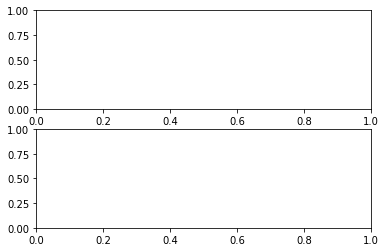

In [25]:
def plot_history(history, metric = None):
  # Plots the loss history of training and validation (if existing)
  # and a given metric
  
  if metric != None:
    fig, axes = plt.subplots(2,1)
    axes[0].plot(history.history[metric])
    try:
      axes[0].plot(history.history['val_'+metric])
      axes[0].legend(['Train', 'Val'])
    except:
      pass
    axes[0].set_title('{:s}'.format(metric))
    axes[0].set_ylabel('{:s}'.format(metric))
    axes[0].set_xlabel('Epoch')
    fig.subplots_adjust(hspace=0.5)
    axes[1].plot(history.history['loss'])
    try:
      axes[1].plot(history.history['val_loss'])
      axes[1].legend(['Train', 'Val'])
    except:
      pass
    axes[1].set_title('Model Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
  else:
    plt.plot(history.history['loss'])
    try:
      plt.plot(history.history['val_loss'])
      plt.legend(['Train', 'Val'])
    except:
      pass
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
  
plot_history(denoise_history_adam, 'mean_absolute_error')
plot_history(denoise_history_adam_amsgrad, 'mean_absolute_error')
plot_history(denoise_history_sgd, 'mean_absolute_error')

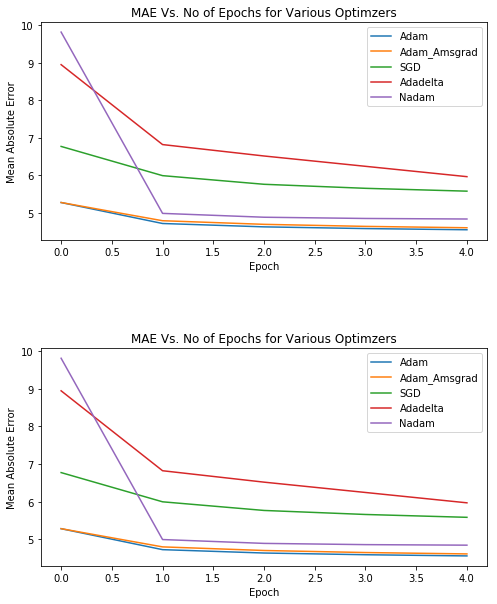

In [30]:
import matplotlib.pyplot as plt
def plot_history(history, history2, history3, history4, history5, metric = None):
  # Plots the loss history of training and validation (if existing)
  # and a given metric
  
  if metric != None:
    fig, axes = plt.subplots(2,1, figsize=(8, 10))
    axes[0].plot(history.history[metric])
    axes[0].plot(history2.history[metric])
    axes[0].plot(history3.history[metric])
    axes[0].plot(history4.history[metric])
    axes[0].plot(history5.history[metric])
    
    try:
      #axes[0].plot(history.history['val_'+metric])
      #axes[0].plot(history2.history['val2_'+metric])
      #axes[0].plot(history3.history['val3_'+metric])
      axes[0].legend(['Adam', 'Adam_Amsgrad', 'SGD', 'Adadelta', 'Nadam' ], loc='best')
    except:
      pass
    axes[0].set_title('MAE Vs. No of Epochs for Various Optimzers')
    axes[0].set_ylabel('Mean Absolute Error')
    axes[0].set_xlabel('Epoch')
    fig.subplots_adjust(hspace=0.5)
    axes[1].plot(history.history['loss'])
    axes[1].plot(history2.history['loss'])
    axes[1].plot(history3.history['loss'])
    axes[1].plot(history4.history['loss'])
    axes[1].plot(history5.history['loss'])
    try:
      #axes[1].plot(history.history['val_loss'])
      axes[1].legend(['Adam', 'Adam_Amsgrad', 'SGD', 'Adadelta', 'Nadam' ])
    except:
      pass
    axes[1].set_title('MAE Vs. No of Epochs for Various Optimzers')
    axes[1].set_ylabel('Mean Absolute Error')
    axes[1].set_xlabel('Epoch')
  else:
    plt.plot(history.history['loss'])
    try:
      plt.plot(history.history['val_loss'])
      plt.legend(['Train', 'Val'])
    except:
      pass
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
  
plot_history(denoise_history_adam, denoise_history_adam_amsgrad, denoise_history_sgd, denoise_history_adadelta, denoise_history_nadam, 'mean_absolute_error')

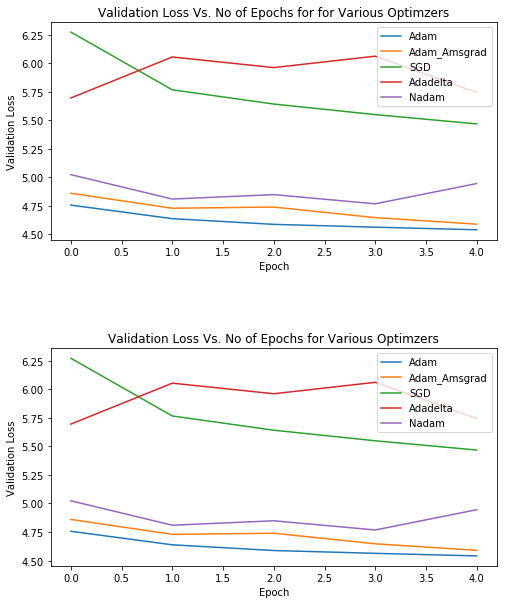

In [31]:
def plot_val_history(history, history2, history3, history4, history5, metric = None):
  # Plots the loss history of training and validation (if existing)
  # and a given metric
  
  if metric != None:
    fig, axes = plt.subplots(2,1, figsize=(8, 10))
    #axes[0].plot(history.history[metric])
    #axes[0].plot(history2.history[metric])
    #axes[0].plot(history3.history[metric])
    try:
      axes[0].plot(history.history['val_'+metric])
      axes[0].plot(history2.history['val_'+metric])
      axes[0].plot(history3.history['val_'+metric])
      axes[0].plot(history4.history['val_'+metric])
      axes[0].plot(history5.history['val_'+metric])
      axes[0].legend(['Adam', 'Adam_Amsgrad', 'SGD', 'Adadelta', 'Nadam'])
    except:
      pass
    axes[0].set_title('Validation Loss Vs. No of Epochs for for Various Optimzers')
    axes[0].set_ylabel('Validation Loss')
    axes[0].set_xlabel('Epoch')
    fig.subplots_adjust(hspace=0.5)
    #axes[1].plot(history.history['loss'])
    #axes[1].plot(history2.history['loss'])
    #axes[1].plot(history3.history['loss'])
    try:
      axes[1].plot(history.history['val_loss'])
      axes[1].plot(history2.history['val_loss'])
      axes[1].plot(history3.history['val_loss'])
      axes[1].plot(history4.history['val_loss'])
      axes[1].plot(history5.history['val_loss'])
      axes[1].legend(['Adam', 'Adam_Amsgrad', 'SGD', 'Adadelta', 'Nadam'])
    except:
      pass
    axes[1].set_title('Validation Loss Vs. No of Epochs for Various Optimzers')
    axes[1].set_ylabel('Validation Loss')
    axes[1].set_xlabel('Epoch')
  else:
    plt.plot(history.history['loss'])
    try:
      plt.plot(history.history['val_loss'])
      plt.legend(['Train', 'Val'])
    except:
      pass
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
  
plot_val_history(denoise_history_adam, denoise_history_adam_amsgrad, denoise_history_sgd, denoise_history_adadelta, denoise_history_nadam, 'mean_absolute_error')

## Training a Descriptor Network
In the last section we trained a model that given a noisy patch, outputs a denoised version of it. We hoped that by doing so, we will improve the performance of the second part, which is training a network that outputs the descriptor. As we mentioned, a descriptor is a numerical vector that represents the small images we have. The dataset consists of a large number of small images, which are cropped patches from other larger images. Hence, they represent some local part of a scene. That is why there are no objects represented, only corners or textures. Each of these patches is related to a subset of other patches of the dataset by some kind of geometric transformation (e.g. rotation).  For a given patch, we want the network to output a vector that is close to the vectors of the patches that represent the same local part of a scene, while being far from patches do not represent that local part of a scene.

To do so, we will build a convolutional neural network that takes the input of $32\times32$ and outputs a descriptor of size $128$. For the loss, we use the triplet loss, which takes an anchor patch, a negative patch and a positive patch. The idea is to train the network so the descriptors from the anchor and positive patch have a low distance between them, and the negative and anchor patch have a large distance between them. 

In this cell we generate a triplet network, which is a network formed by three copies of the same network. That means that the descriptor model will compute the descriptor for the input `'a'` (anchor), the same descriptor model (with the same weights) will compute the descriptor for the input `'p'` (positive), and again the same model will compute the descriptor for the input `'n'` (negative). 

**Updated explanation**: Due to the way Keras handles the compile method, it needs a loss as an argument in that compile method. However, our loss is computed in the lambda layer, so we want to minimize the output of that layer. As we want to minimize the output of the Lambda function (in this case the triplet loss), we output as the label in the training_generator a vector of zeros and we compute the mean absolute error of the triplet loss and this vector of zeros. To give you an intuition, what we aim to minimize is
$$  |\text{triplet_loss} - 0| =  |\text{triplet_loss}| = \text{triplet_loss} $$



In [32]:
from keras.layers import Lambda
shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')
descriptor_model = get_descriptor_model(shape)
ea = descriptor_model(xa)
ep = descriptor_model(xp)
en = descriptor_model(xn)

loss = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_trip = Model(inputs=[xa, xp, xn], outputs=loss)
sgd = keras.optimizers.SGD(lr=0.1)
descriptor_model_trip.compile(loss='mean_absolute_error', optimizer=sgd)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Here we use the class HPatches, which loads the corresponding files by using the method `read_image_file`. It reads the patches. The output of read_image_file is a tuple of the form (images, labels), which is passed to the class `DataGeneratorDesc`. This class is a generator that creates batches of triplets, and each epoch is defined by the number of triplets in the argument `num_triplets`.

**Updated**: In the previous version of the baseline code, we were training the descriptor model with the noisy patches, not with the denoised ones. By adding the argument `denoise_model=denoise_model` to the class HPatches we can use the denoised images instead to train this descriptor model (if `denoise_model=None`, the noisy patches will be used). However, as it has to compute the denoised patch first, the loading of the data will be slower (6/7 extra min).  If you want to train the model with the clean patches instead, you can set the argument `use_clean=True`. In this last case, even if a denoise model is given, it will not be used. When running this piece of code **the type of patches (denoised, noisy or clean) used is printed**.

In [35]:
### Descriptor loading and training
# Loading images
hPatches_adam = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model_adam, use_clean=False)
hPatches_adam_amsgrad = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model_adam_amsgrad, use_clean=False)
hPatches_sgd = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model_sgd, use_clean=False)
hPatches_adadelta = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model_adadelta, use_clean=False)
hPatches_nadam = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model_nadam, use_clean=False)

# Creating training generator
training_generator_adam = DataGeneratorDesc(*hPatches_adam.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator_adam = DataGeneratorDesc(*hPatches_adam.read_image_file(hpatches_dir, train=0), num_triplets=10000)

# Creating training generator
training_generator_adam_amsgrad = DataGeneratorDesc(*hPatches_adam_amsgrad.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator_adam_amsgrad = DataGeneratorDesc(*hPatches_adam_amsgrad.read_image_file(hpatches_dir, train=0), num_triplets=10000)

# Creating training generator
training_generator_sgd = DataGeneratorDesc(*hPatches_sgd.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator_sgd = DataGeneratorDesc(*hPatches_sgd.read_image_file(hpatches_dir, train=0), num_triplets=10000)

# Creating training generator
training_generator_adadelta = DataGeneratorDesc(*hPatches_adadelta.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator_adadelta = DataGeneratorDesc(*hPatches_adadelta.read_image_file(hpatches_dir, train=0), num_triplets=10000)

# Creating training generator
training_generator_nadam = DataGeneratorDesc(*hPatches_nadam.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator_nadam = DataGeneratorDesc(*hPatches_nadam.read_image_file(hpatches_dir, train=0), num_triplets=10000)

Using denoised patches
100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [00:45<00:00,  2.55it/s]
Denoising patches...
100%|████████████████████████████████████████████████████████████████████████████| 15589/15589 [07:58<00:00, 32.57it/s]


100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 60285.40it/s]


Using denoised patches
100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [00:24<00:00,  5.50it/s]
Denoising patches...
100%|██████████████████████████████████████████████████████████████████████████████| 9525/9525 [04:48<00:00, 33.06it/s]


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 31235.97it/s]


Using denoised patches
100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [00:48<00:00,  2.41it/s]
Denoising patches...
100%|████████████████████████████████████████████████████████████████████████████| 15589/15589 [07:51<00:00, 33.04it/s]


100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 45994.24it/s]


Using denoised patches
100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [00:18<00:00,  5.57it/s]
Denoising patches...
100%|██████████████████████████████████████████████████████████████████████████████| 9525/9525 [04:48<00:00, 33.07it/s]


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 39161.62it/s]


Using denoised patches
100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [00:41<00:00,  2.80it/s]
Denoising patches...
100%|████████████████████████████████████████████████████████████████████████████| 15589/15589 [07:57<00:00, 32.68it/s]


100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 48698.55it/s]


Using denoised patches
100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [00:16<00:00,  5.54it/s]
Denoising patches...
100%|██████████████████████████████████████████████████████████████████████████████| 9525/9525 [04:43<00:00, 33.65it/s]


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 42841.29it/s]


Using denoised patches
100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [00:36<00:00,  3.20it/s]
Denoising patches...
100%|████████████████████████████████████████████████████████████████████████████| 15589/15589 [07:28<00:00, 34.79it/s]


100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 59153.82it/s]


Using denoised patches
100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [00:18<00:00,  2.91it/s]
Denoising patches...
100%|██████████████████████████████████████████████████████████████████████████████| 9525/9525 [04:27<00:00, 35.60it/s]


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 50891.43it/s]


Using denoised patches
100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [00:42<00:00,  2.75it/s]
Denoising patches...
100%|████████████████████████████████████████████████████████████████████████████| 15589/15589 [07:23<00:00, 35.19it/s]


100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 59717.42it/s]


Using denoised patches
100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [00:23<00:00,  1.99it/s]
Denoising patches...
100%|██████████████████████████████████████████████████████████████████████████████| 9525/9525 [04:25<00:00, 35.84it/s]


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 45166.72it/s]


We plot a random triplet in the form of anchor, positive and negative sample. The positive and anchor patches are similar between them (the difference is a geometric transformation, for example rotation), whereas the negative sample should be quite dissimilar to any of the other two.

In [ ]:
plot_triplet(training_generator)

We now train the descriptor model and save the weights afterward.

In [36]:
#epochs = 1
### As with the denoising model, we use a loop to save for each epoch 
## #the weights in an external website in case colab stops. 
### reset, so e.g. calling 5 times fit(epochs=1) behave as fit(epochs=5)

### If you have a model saved from a previous training session
### Load it in the next line
# descriptor_model_trip.set_weights(keras.models.load_model('./descriptor.h5').get_weights())
# descriptor_model_trip.optimizer = keras.models.load_model('./descriptor.h5').optimizer

#for e in range(epochs):
  
descriptor_history_adam = descriptor_model_trip.fit_generator(generator=training_generator_adam, epochs=5, verbose=1, validation_data=val_generator_adam)
descriptor_model_trip.save('descriptor_adam.h5') 

descriptor_history_adam_amsgrad = descriptor_model_trip.fit_generator(generator=training_generator_adam_amsgrad, epochs=5, verbose=1, validation_data=val_generator_adam_amsgrad)
descriptor_model_trip.save('descriptor_adam_amsgrad.h5') 

descriptor_history_sgd = descriptor_model_trip.fit_generator(generator=training_generator_sgd, epochs=5, verbose=1, validation_data=val_generator_sgd)
descriptor_model_trip.save('descriptor_sgd.h5') 

descriptor_history_adadelta = descriptor_model_trip.fit_generator(generator=training_generator_adadelta, epochs=5, verbose=1, validation_data=val_generator_adadelta)
descriptor_model_trip.save('descriptor_adadelta.h5') 

descriptor_history_nadam = descriptor_model_trip.fit_generator(generator=training_generator_nadam, epochs=5, verbose=1, validation_data=val_generator_nadam)
descriptor_model_trip.save('descriptor_nadam.h5') 

### Saves optimizer and weights
#descriptor_model_trip.save('descriptor.h5') 
### Uploads files to external hosting
#!curl -F "file=@descriptor.h5" https://file.io


Epoch 1/5


 326/2000 [===>..........................] - ETA: 1:34:37 - loss: 0.85 - ETA: 32:26 - loss: 0.7431 - ETA: 24:46 - loss: 0.63 - ETA: 20:12 - loss: 0.65 - ETA: 17:07 - loss: 0.61 - ETA: 14:56 - loss: 0.62 - ETA: 13:17 - loss: 0.59 - ETA: 12:00 - loss: 0.59 - ETA: 10:59 - loss: 0.57 - ETA: 10:10 - loss: 0.57 - ETA: 9:28 - loss: 0.5507 - ETA: 8:53 - loss: 0.527 - ETA: 8:23 - loss: 0.526 - ETA: 7:56 - loss: 0.510 - ETA: 7:34 - loss: 0.505 - ETA: 7:13 - loss: 0.497 - ETA: 6:55 - loss: 0.482 - ETA: 6:38 - loss: 0.474 - ETA: 6:23 - loss: 0.476 - ETA: 6:10 - loss: 0.465 - ETA: 5:58 - loss: 0.456 - ETA: 5:47 - loss: 0.457 - ETA: 5:37 - loss: 0.455 - ETA: 5:27 - loss: 0.456 - ETA: 5:19 - loss: 0.449 - ETA: 5:11 - loss: 0.441 - ETA: 5:03 - loss: 0.446 - ETA: 4:56 - loss: 0.442 - ETA: 4:50 - loss: 0.441 - ETA: 4:44 - loss: 0.438 - ETA: 4:38 - loss: 0.438 - ETA: 4:33 - loss: 0.433 - ETA: 4:28 - loss: 0.429 - ETA: 4:23 - loss: 0.428 - ETA: 4:19 - loss: 0.426 - ETA: 4:15 - loss: 0.421 - ETA: 4:11 - lo

 688/2000 [=========>....................] - ETA: 1:45 - loss: 0.292 - ETA: 1:45 - loss: 0.292 - ETA: 1:45 - loss: 0.292 - ETA: 1:44 - loss: 0.291 - ETA: 1:44 - loss: 0.291 - ETA: 1:44 - loss: 0.291 - ETA: 1:44 - loss: 0.291 - ETA: 1:44 - loss: 0.291 - ETA: 1:44 - loss: 0.290 - ETA: 1:43 - loss: 0.290 - ETA: 1:43 - loss: 0.290 - ETA: 1:43 - loss: 0.289 - ETA: 1:43 - loss: 0.289 - ETA: 1:43 - loss: 0.289 - ETA: 1:43 - loss: 0.289 - ETA: 1:43 - loss: 0.288 - ETA: 1:43 - loss: 0.289 - ETA: 1:42 - loss: 0.289 - ETA: 1:42 - loss: 0.289 - ETA: 1:42 - loss: 0.289 - ETA: 1:42 - loss: 0.288 - ETA: 1:42 - loss: 0.288 - ETA: 1:42 - loss: 0.288 - ETA: 1:42 - loss: 0.288 - ETA: 1:42 - loss: 0.288 - ETA: 1:42 - loss: 0.287 - ETA: 1:41 - loss: 0.287 - ETA: 1:41 - loss: 0.286 - ETA: 1:41 - loss: 0.286 - ETA: 1:41 - loss: 0.285 - ETA: 1:41 - loss: 0.285 - ETA: 1:41 - loss: 0.285 - ETA: 1:41 - loss: 0.285 - ETA: 1:41 - loss: 0.285 - ETA: 1:41 - loss: 0.285 - ETA: 1:40 - loss: 0.285 - ETA: 1:40 - loss: 0

1088/2000 [===============>..............] - ETA: 1:15 - loss: 0.255 - ETA: 1:15 - loss: 0.255 - ETA: 1:14 - loss: 0.255 - ETA: 1:14 - loss: 0.255 - ETA: 1:14 - loss: 0.255 - ETA: 1:14 - loss: 0.255 - ETA: 1:14 - loss: 0.254 - ETA: 1:14 - loss: 0.254 - ETA: 1:14 - loss: 0.254 - ETA: 1:14 - loss: 0.254 - ETA: 1:14 - loss: 0.254 - ETA: 1:14 - loss: 0.254 - ETA: 1:13 - loss: 0.254 - ETA: 1:13 - loss: 0.254 - ETA: 1:13 - loss: 0.254 - ETA: 1:13 - loss: 0.254 - ETA: 1:13 - loss: 0.254 - ETA: 1:13 - loss: 0.254 - ETA: 1:13 - loss: 0.254 - ETA: 1:13 - loss: 0.254 - ETA: 1:13 - loss: 0.254 - ETA: 1:13 - loss: 0.254 - ETA: 1:13 - loss: 0.254 - ETA: 1:13 - loss: 0.254 - ETA: 1:13 - loss: 0.254 - ETA: 1:13 - loss: 0.254 - ETA: 1:12 - loss: 0.254 - ETA: 1:12 - loss: 0.254 - ETA: 1:12 - loss: 0.254 - ETA: 1:12 - loss: 0.254 - ETA: 1:12 - loss: 0.253 - ETA: 1:12 - loss: 0.253 - ETA: 1:12 - loss: 0.253 - ETA: 1:12 - loss: 0.253 - ETA: 1:12 - loss: 0.253 - ETA: 1:12 - loss: 0.253 - ETA: 1:12 - loss: 0

1491/2000 [=====================>........] - ETA: 50s - loss: 0.23 - ETA: 50s - loss: 0.23 - ETA: 50s - loss: 0.23 - ETA: 50s - loss: 0.23 - ETA: 49s - loss: 0.23 - ETA: 49s - loss: 0.23 - ETA: 49s - loss: 0.23 - ETA: 49s - loss: 0.23 - ETA: 49s - loss: 0.23 - ETA: 49s - loss: 0.23 - ETA: 49s - loss: 0.23 - ETA: 49s - loss: 0.23 - ETA: 49s - loss: 0.23 - ETA: 49s - loss: 0.23 - ETA: 49s - loss: 0.23 - ETA: 49s - loss: 0.23 - ETA: 48s - loss: 0.23 - ETA: 48s - loss: 0.23 - ETA: 48s - loss: 0.23 - ETA: 48s - loss: 0.23 - ETA: 48s - loss: 0.23 - ETA: 48s - loss: 0.23 - ETA: 48s - loss: 0.23 - ETA: 48s - loss: 0.23 - ETA: 48s - loss: 0.23 - ETA: 48s - loss: 0.23 - ETA: 48s - loss: 0.23 - ETA: 48s - loss: 0.23 - ETA: 48s - loss: 0.23 - ETA: 47s - loss: 0.23 - ETA: 47s - loss: 0.23 - ETA: 47s - loss: 0.23 - ETA: 47s - loss: 0.23 - ETA: 47s - loss: 0.23 - ETA: 47s - loss: 0.23 - ETA: 47s - loss: 0.23 - ETA: 47s - loss: 0.23 - ETA: 47s - loss: 0.23 - ETA: 47s - loss: 0.23 - ETA: 47s - loss: 0.

1902/2000 [===========================>..] - ETA: 27s - loss: 0.22 - ETA: 27s - loss: 0.22 - ETA: 27s - loss: 0.21 - ETA: 27s - loss: 0.22 - ETA: 27s - loss: 0.21 - ETA: 27s - loss: 0.21 - ETA: 27s - loss: 0.21 - ETA: 27s - loss: 0.21 - ETA: 27s - loss: 0.21 - ETA: 27s - loss: 0.21 - ETA: 27s - loss: 0.21 - ETA: 27s - loss: 0.21 - ETA: 26s - loss: 0.21 - ETA: 26s - loss: 0.21 - ETA: 26s - loss: 0.21 - ETA: 26s - loss: 0.21 - ETA: 26s - loss: 0.21 - ETA: 26s - loss: 0.21 - ETA: 26s - loss: 0.21 - ETA: 26s - loss: 0.21 - ETA: 26s - loss: 0.21 - ETA: 26s - loss: 0.21 - ETA: 26s - loss: 0.21 - ETA: 26s - loss: 0.21 - ETA: 26s - loss: 0.21 - ETA: 26s - loss: 0.21 - ETA: 26s - loss: 0.21 - ETA: 25s - loss: 0.21 - ETA: 25s - loss: 0.21 - ETA: 25s - loss: 0.21 - ETA: 25s - loss: 0.21 - ETA: 25s - loss: 0.21 - ETA: 25s - loss: 0.21 - ETA: 25s - loss: 0.21 - ETA: 25s - loss: 0.21 - ETA: 25s - loss: 0.21 - ETA: 25s - loss: 0.21 - ETA: 25s - loss: 0.21 - ETA: 25s - loss: 0.21 - ETA: 24s - loss: 0.

1998/2000 [============================>.] - ETA: 5s - loss: 0.209 - ETA: 5s - loss: 0.209 - ETA: 5s - loss: 0.209 - ETA: 4s - loss: 0.209 - ETA: 4s - loss: 0.209 - ETA: 4s - loss: 0.209 - ETA: 4s - loss: 0.209 - ETA: 4s - loss: 0.209 - ETA: 4s - loss: 0.209 - ETA: 4s - loss: 0.209 - ETA: 4s - loss: 0.209 - ETA: 4s - loss: 0.209 - ETA: 4s - loss: 0.209 - ETA: 4s - loss: 0.209 - ETA: 4s - loss: 0.209 - ETA: 4s - loss: 0.209 - ETA: 4s - loss: 0.209 - ETA: 3s - loss: 0.209 - ETA: 3s - loss: 0.209 - ETA: 3s - loss: 0.209 - ETA: 3s - loss: 0.209 - ETA: 3s - loss: 0.209 - ETA: 3s - loss: 0.209 - ETA: 3s - loss: 0.209 - ETA: 3s - loss: 0.209 - ETA: 3s - loss: 0.209 - ETA: 3s - loss: 0.209 - ETA: 3s - loss: 0.209 - ETA: 3s - loss: 0.209 - ETA: 3s - loss: 0.209 - ETA: 3s - loss: 0.209 - ETA: 3s - loss: 0.209 - ETA: 3s - loss: 0.209 - ETA: 3s - loss: 0.209 - ETA: 2s - loss: 0.209 - ETA: 2s - loss: 0.209 - ETA: 2s - loss: 0.209 - ETA: 2s - loss: 0.209 - ETA: 2s - loss: 0.209 - ETA: 2s - loss: 0.2

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 49640.25it/s]


2000/2000 [==============================] - 113s 57ms/step - loss: 0.2080 - val_loss: 0.2323
Epoch 2/5
   3/2000 [..............................] - ETA: 1:29 - loss: 0.111 - ETA: 3:38 - loss: 0.183 - ETA: 5:00 - loss: 0.1737

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.167542). Check your callbacks.
  % delta_t_median)


   4/2000 [..............................] - ETA: 5:40 - loss: 0.1620

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127646). Check your callbacks.
  % delta_t_median)


   7/2000 [..............................] - ETA: 5:34 - loss: 0.146 - ETA: 6:05 - loss: 0.145 - ETA: 5:34 - loss: 0.1740

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]



 22%|████████████████▎                                                          | 2180/10000 [00:00<00:02, 3736.44it/s]

   8/2000 [..............................] - ETA: 5:10 - loss: 0.1737

 62%|██████████████████████████████████████████████▌                            | 6213/10000 [00:00<00:00, 5133.61it/s]

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 12831.47it/s]

   9/2000 [..............................] - ETA: 7:12 - loss: 0.1678

 414/2000 [=====>........................] - ETA: 7:00 - loss: 0.167 - ETA: 6:06 - loss: 0.152 - ETA: 5:45 - loss: 0.154 - ETA: 5:28 - loss: 0.168 - ETA: 4:58 - loss: 0.159 - ETA: 4:46 - loss: 0.161 - ETA: 4:25 - loss: 0.162 - ETA: 4:17 - loss: 0.165 - ETA: 4:09 - loss: 0.167 - ETA: 3:55 - loss: 0.169 - ETA: 3:43 - loss: 0.162 - ETA: 3:38 - loss: 0.163 - ETA: 3:28 - loss: 0.155 - ETA: 3:25 - loss: 0.153 - ETA: 3:17 - loss: 0.149 - ETA: 3:14 - loss: 0.151 - ETA: 3:08 - loss: 0.150 - ETA: 3:05 - loss: 0.148 - ETA: 3:03 - loss: 0.147 - ETA: 3:01 - loss: 0.146 - ETA: 2:59 - loss: 0.145 - ETA: 2:57 - loss: 0.147 - ETA: 2:55 - loss: 0.146 - ETA: 2:53 - loss: 0.147 - ETA: 2:51 - loss: 0.146 - ETA: 2:49 - loss: 0.147 - ETA: 2:46 - loss: 0.146 - ETA: 2:44 - loss: 0.148 - ETA: 2:43 - loss: 0.146 - ETA: 2:42 - loss: 0.147 - ETA: 2:40 - loss: 0.147 - ETA: 2:37 - loss: 0.145 - ETA: 2:36 - loss: 0.145 - ETA: 2:35 - loss: 0.148 - ETA: 2:33 - loss: 0.147 - ETA: 2:30 - loss: 0.145 - ETA: 2:28 - loss: 0

 816/2000 [===========>..................] - ETA: 1:26 - loss: 0.163 - ETA: 1:26 - loss: 0.164 - ETA: 1:26 - loss: 0.163 - ETA: 1:26 - loss: 0.164 - ETA: 1:26 - loss: 0.164 - ETA: 1:25 - loss: 0.163 - ETA: 1:25 - loss: 0.164 - ETA: 1:25 - loss: 0.164 - ETA: 1:25 - loss: 0.164 - ETA: 1:25 - loss: 0.164 - ETA: 1:25 - loss: 0.164 - ETA: 1:25 - loss: 0.164 - ETA: 1:25 - loss: 0.164 - ETA: 1:25 - loss: 0.164 - ETA: 1:25 - loss: 0.164 - ETA: 1:25 - loss: 0.164 - ETA: 1:25 - loss: 0.163 - ETA: 1:24 - loss: 0.163 - ETA: 1:24 - loss: 0.163 - ETA: 1:24 - loss: 0.163 - ETA: 1:24 - loss: 0.163 - ETA: 1:24 - loss: 0.162 - ETA: 1:24 - loss: 0.162 - ETA: 1:24 - loss: 0.162 - ETA: 1:24 - loss: 0.162 - ETA: 1:24 - loss: 0.162 - ETA: 1:23 - loss: 0.162 - ETA: 1:23 - loss: 0.162 - ETA: 1:23 - loss: 0.163 - ETA: 1:23 - loss: 0.162 - ETA: 1:23 - loss: 0.162 - ETA: 1:23 - loss: 0.162 - ETA: 1:23 - loss: 0.162 - ETA: 1:23 - loss: 0.162 - ETA: 1:23 - loss: 0.162 - ETA: 1:23 - loss: 0.162 - ETA: 1:23 - loss: 0

1227/2000 [=================>............] - ETA: 1:02 - loss: 0.160 - ETA: 1:02 - loss: 0.160 - ETA: 1:01 - loss: 0.160 - ETA: 1:01 - loss: 0.160 - ETA: 1:01 - loss: 0.160 - ETA: 1:01 - loss: 0.160 - ETA: 1:01 - loss: 0.160 - ETA: 1:01 - loss: 0.160 - ETA: 1:01 - loss: 0.160 - ETA: 1:01 - loss: 0.160 - ETA: 1:01 - loss: 0.160 - ETA: 1:01 - loss: 0.160 - ETA: 1:01 - loss: 0.160 - ETA: 1:01 - loss: 0.160 - ETA: 1:01 - loss: 0.160 - ETA: 1:01 - loss: 0.160 - ETA: 1:00 - loss: 0.160 - ETA: 1:00 - loss: 0.160 - ETA: 1:00 - loss: 0.160 - ETA: 1:00 - loss: 0.160 - ETA: 1:00 - loss: 0.160 - ETA: 1:00 - loss: 0.160 - ETA: 1:00 - loss: 0.160 - ETA: 1:00 - loss: 0.160 - ETA: 1:00 - loss: 0.160 - ETA: 1:00 - loss: 0.160 - ETA: 1:00 - loss: 0.160 - ETA: 1:00 - loss: 0.160 - ETA: 59s - loss: 0.160 - ETA: 59s - loss: 0.16 - ETA: 59s - loss: 0.16 - ETA: 59s - loss: 0.16 - ETA: 59s - loss: 0.16 - ETA: 59s - loss: 0.16 - ETA: 59s - loss: 0.16 - ETA: 59s - loss: 0.16 - ETA: 59s - loss: 0.16 - ETA: 59s -

1680/2000 [========================>.....] - ETA: 40s - loss: 0.15 - ETA: 40s - loss: 0.15 - ETA: 40s - loss: 0.15 - ETA: 40s - loss: 0.15 - ETA: 40s - loss: 0.15 - ETA: 40s - loss: 0.15 - ETA: 40s - loss: 0.15 - ETA: 40s - loss: 0.15 - ETA: 40s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 39s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 38s - loss: 0.15 - ETA: 37s - loss: 0.15 - ETA: 37s - loss: 0.15 - ETA: 37s - loss: 0.

1998/2000 [============================>.] - ETA: 16s - loss: 0.15 - ETA: 16s - loss: 0.15 - ETA: 16s - loss: 0.15 - ETA: 16s - loss: 0.15 - ETA: 16s - loss: 0.15 - ETA: 16s - loss: 0.15 - ETA: 16s - loss: 0.15 - ETA: 15s - loss: 0.15 - ETA: 15s - loss: 0.15 - ETA: 15s - loss: 0.15 - ETA: 15s - loss: 0.15 - ETA: 15s - loss: 0.15 - ETA: 15s - loss: 0.15 - ETA: 15s - loss: 0.15 - ETA: 15s - loss: 0.15 - ETA: 15s - loss: 0.15 - ETA: 15s - loss: 0.15 - ETA: 15s - loss: 0.15 - ETA: 15s - loss: 0.15 - ETA: 14s - loss: 0.15 - ETA: 14s - loss: 0.15 - ETA: 14s - loss: 0.15 - ETA: 14s - loss: 0.15 - ETA: 14s - loss: 0.15 - ETA: 14s - loss: 0.15 - ETA: 14s - loss: 0.15 - ETA: 14s - loss: 0.15 - ETA: 14s - loss: 0.15 - ETA: 14s - loss: 0.15 - ETA: 14s - loss: 0.15 - ETA: 13s - loss: 0.15 - ETA: 13s - loss: 0.15 - ETA: 13s - loss: 0.15 - ETA: 13s - loss: 0.15 - ETA: 13s - loss: 0.15 - ETA: 13s - loss: 0.15 - ETA: 13s - loss: 0.15 - ETA: 13s - loss: 0.15 - ETA: 13s - loss: 0.15 - ETA: 13s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 46562.19it/s]


2000/2000 [==============================] - 110s 55ms/step - loss: 0.1534 - val_loss: 0.1658
Epoch 3/5
   2/2000 [..............................] - ETA: 6:28 - loss: 0.140 - ETA: 6:10 - loss: 0.1391

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107219). Check your callbacks.
  % delta_t_median)


   3/2000 [..............................] - ETA: 6:23 - loss: 0.1269

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107749). Check your callbacks.
  % delta_t_median)


   6/2000 [..............................] - ETA: 6:39 - loss: 0.114 - ETA: 7:36 - loss: 0.119 - ETA: 6:48 - loss: 0.1078

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103210). Check your callbacks.
  % delta_t_median)
  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

 40%|█████████████████████████████▍                                            | 3973/10000 [00:00<00:00, 39428.66it/s]

   7/2000 [..............................] - ETA: 6:13 - loss: 0.1043

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106689). Check your callbacks.
  % delta_t_median)
 78%|█████████████████████████████████████████████████████████▋                | 7799/10000 [00:00<00:00, 38983.43it/s]



100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 37136.14it/s]

   8/2000 [..............................] - ETA: 6:20 - loss: 0.1025

 404/2000 [=====>........................] - ETA: 6:04 - loss: 0.097 - ETA: 5:38 - loss: 0.106 - ETA: 5:17 - loss: 0.101 - ETA: 5:00 - loss: 0.094 - ETA: 4:45 - loss: 0.097 - ETA: 4:34 - loss: 0.092 - ETA: 4:22 - loss: 0.092 - ETA: 4:12 - loss: 0.093 - ETA: 4:03 - loss: 0.095 - ETA: 3:56 - loss: 0.096 - ETA: 3:49 - loss: 0.094 - ETA: 3:43 - loss: 0.096 - ETA: 3:37 - loss: 0.094 - ETA: 3:33 - loss: 0.100 - ETA: 3:28 - loss: 0.105 - ETA: 3:24 - loss: 0.106 - ETA: 3:20 - loss: 0.111 - ETA: 3:17 - loss: 0.109 - ETA: 3:13 - loss: 0.109 - ETA: 3:10 - loss: 0.112 - ETA: 3:07 - loss: 0.112 - ETA: 3:05 - loss: 0.113 - ETA: 3:02 - loss: 0.116 - ETA: 3:00 - loss: 0.115 - ETA: 2:58 - loss: 0.119 - ETA: 2:56 - loss: 0.121 - ETA: 2:54 - loss: 0.122 - ETA: 2:52 - loss: 0.120 - ETA: 2:50 - loss: 0.122 - ETA: 2:48 - loss: 0.122 - ETA: 2:44 - loss: 0.123 - ETA: 2:43 - loss: 0.124 - ETA: 2:39 - loss: 0.126 - ETA: 2:38 - loss: 0.127 - ETA: 2:37 - loss: 0.127 - ETA: 2:36 - loss: 0.128 - ETA: 2:34 - loss: 0

 824/2000 [===========>..................] - ETA: 1:26 - loss: 0.134 - ETA: 1:26 - loss: 0.134 - ETA: 1:26 - loss: 0.134 - ETA: 1:26 - loss: 0.134 - ETA: 1:26 - loss: 0.134 - ETA: 1:26 - loss: 0.134 - ETA: 1:25 - loss: 0.134 - ETA: 1:25 - loss: 0.134 - ETA: 1:25 - loss: 0.134 - ETA: 1:25 - loss: 0.134 - ETA: 1:25 - loss: 0.134 - ETA: 1:25 - loss: 0.134 - ETA: 1:25 - loss: 0.134 - ETA: 1:24 - loss: 0.134 - ETA: 1:24 - loss: 0.134 - ETA: 1:24 - loss: 0.134 - ETA: 1:24 - loss: 0.134 - ETA: 1:24 - loss: 0.134 - ETA: 1:24 - loss: 0.133 - ETA: 1:24 - loss: 0.133 - ETA: 1:23 - loss: 0.133 - ETA: 1:23 - loss: 0.133 - ETA: 1:23 - loss: 0.133 - ETA: 1:23 - loss: 0.134 - ETA: 1:23 - loss: 0.134 - ETA: 1:23 - loss: 0.134 - ETA: 1:23 - loss: 0.135 - ETA: 1:23 - loss: 0.135 - ETA: 1:23 - loss: 0.135 - ETA: 1:23 - loss: 0.135 - ETA: 1:22 - loss: 0.135 - ETA: 1:22 - loss: 0.135 - ETA: 1:22 - loss: 0.135 - ETA: 1:22 - loss: 0.135 - ETA: 1:22 - loss: 0.135 - ETA: 1:22 - loss: 0.135 - ETA: 1:22 - loss: 0

1269/2000 [==================>...........] - ETA: 1:01 - loss: 0.138 - ETA: 1:01 - loss: 0.138 - ETA: 1:01 - loss: 0.138 - ETA: 1:00 - loss: 0.138 - ETA: 1:00 - loss: 0.138 - ETA: 1:00 - loss: 0.138 - ETA: 1:00 - loss: 0.138 - ETA: 1:00 - loss: 0.138 - ETA: 1:00 - loss: 0.138 - ETA: 1:00 - loss: 0.138 - ETA: 1:00 - loss: 0.138 - ETA: 1:00 - loss: 0.138 - ETA: 1:00 - loss: 0.138 - ETA: 1:00 - loss: 0.138 - ETA: 59s - loss: 0.138 - ETA: 59s - loss: 0.13 - ETA: 59s - loss: 0.13 - ETA: 59s - loss: 0.13 - ETA: 59s - loss: 0.13 - ETA: 59s - loss: 0.13 - ETA: 59s - loss: 0.13 - ETA: 59s - loss: 0.13 - ETA: 59s - loss: 0.13 - ETA: 59s - loss: 0.13 - ETA: 59s - loss: 0.13 - ETA: 59s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 58s - loss: 0.13 - ETA: 57s - los

1702/2000 [========================>.....] - ETA: 37s - loss: 0.13 - ETA: 37s - loss: 0.13 - ETA: 37s - loss: 0.13 - ETA: 37s - loss: 0.13 - ETA: 37s - loss: 0.13 - ETA: 37s - loss: 0.13 - ETA: 37s - loss: 0.13 - ETA: 37s - loss: 0.13 - ETA: 37s - loss: 0.13 - ETA: 37s - loss: 0.13 - ETA: 37s - loss: 0.13 - ETA: 37s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 35s - loss: 0.13 - ETA: 35s - loss: 0.13 - ETA: 35s - loss: 0.13 - ETA: 35s - loss: 0.13 - ETA: 35s - loss: 0.13 - ETA: 35s - loss: 0.13 - ETA: 35s - loss: 0.

1998/2000 [============================>.] - ETA: 15s - loss: 0.13 - ETA: 15s - loss: 0.13 - ETA: 15s - loss: 0.13 - ETA: 14s - loss: 0.13 - ETA: 14s - loss: 0.13 - ETA: 14s - loss: 0.13 - ETA: 14s - loss: 0.13 - ETA: 14s - loss: 0.13 - ETA: 14s - loss: 0.13 - ETA: 14s - loss: 0.13 - ETA: 14s - loss: 0.13 - ETA: 14s - loss: 0.13 - ETA: 14s - loss: 0.13 - ETA: 14s - loss: 0.13 - ETA: 14s - loss: 0.13 - ETA: 14s - loss: 0.13 - ETA: 13s - loss: 0.13 - ETA: 13s - loss: 0.13 - ETA: 13s - loss: 0.13 - ETA: 13s - loss: 0.13 - ETA: 13s - loss: 0.13 - ETA: 13s - loss: 0.13 - ETA: 13s - loss: 0.13 - ETA: 13s - loss: 0.13 - ETA: 13s - loss: 0.13 - ETA: 13s - loss: 0.13 - ETA: 13s - loss: 0.13 - ETA: 13s - loss: 0.13 - ETA: 12s - loss: 0.13 - ETA: 12s - loss: 0.13 - ETA: 12s - loss: 0.13 - ETA: 12s - loss: 0.13 - ETA: 12s - loss: 0.13 - ETA: 12s - loss: 0.13 - ETA: 12s - loss: 0.13 - ETA: 12s - loss: 0.13 - ETA: 12s - loss: 0.13 - ETA: 12s - loss: 0.13 - ETA: 12s - loss: 0.13 - ETA: 12s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 47813.04it/s]


2000/2000 [==============================] - 109s 55ms/step - loss: 0.1342 - val_loss: 0.1869
Epoch 4/5
   6/2000 [..............................] - ETA: 5:28 - loss: 0.066 - ETA: 5:39 - loss: 0.072 - ETA: 5:18 - loss: 0.110 - ETA: 5:29 - loss: 0.089 - ETA: 5:12 - loss: 0.094 - ETA: 5:52 - loss: 0.0850

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   7/2000 [..............................] - ETA: 5:25 - loss: 0.0850

 36%|██████████████████████████▌                                               | 3593/10000 [00:00<00:00, 35652.16it/s]



 72%|████████████████████████████████████████████████████▉                     | 7160/10000 [00:00<00:00, 35580.57it/s]

   8/2000 [..............................] - ETA: 5:31 - loss: 0.0905

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 33413.67it/s]



 395/2000 [====>.........................] - ETA: 5:15 - loss: 0.089 - ETA: 5:06 - loss: 0.103 - ETA: 4:48 - loss: 0.105 - ETA: 4:18 - loss: 0.119 - ETA: 4:07 - loss: 0.130 - ETA: 3:58 - loss: 0.132 - ETA: 3:40 - loss: 0.134 - ETA: 3:33 - loss: 0.130 - ETA: 3:27 - loss: 0.126 - ETA: 3:22 - loss: 0.127 - ETA: 3:18 - loss: 0.126 - ETA: 3:14 - loss: 0.125 - ETA: 3:11 - loss: 0.125 - ETA: 3:07 - loss: 0.125 - ETA: 3:05 - loss: 0.129 - ETA: 3:02 - loss: 0.126 - ETA: 2:59 - loss: 0.125 - ETA: 2:56 - loss: 0.125 - ETA: 2:54 - loss: 0.124 - ETA: 2:53 - loss: 0.122 - ETA: 2:51 - loss: 0.121 - ETA: 2:49 - loss: 0.118 - ETA: 2:47 - loss: 0.121 - ETA: 2:45 - loss: 0.121 - ETA: 2:44 - loss: 0.121 - ETA: 2:42 - loss: 0.124 - ETA: 2:41 - loss: 0.124 - ETA: 2:39 - loss: 0.122 - ETA: 2:38 - loss: 0.123 - ETA: 2:36 - loss: 0.123 - ETA: 2:35 - loss: 0.124 - ETA: 2:34 - loss: 0.126 - ETA: 2:33 - loss: 0.128 - ETA: 2:32 - loss: 0.127 - ETA: 2:31 - loss: 0.131 - ETA: 2:30 - loss: 0.129 - ETA: 2:29 - loss: 0

 824/2000 [===========>..................] - ETA: 1:25 - loss: 0.126 - ETA: 1:25 - loss: 0.126 - ETA: 1:25 - loss: 0.127 - ETA: 1:25 - loss: 0.127 - ETA: 1:25 - loss: 0.127 - ETA: 1:25 - loss: 0.127 - ETA: 1:25 - loss: 0.127 - ETA: 1:25 - loss: 0.127 - ETA: 1:25 - loss: 0.127 - ETA: 1:25 - loss: 0.127 - ETA: 1:25 - loss: 0.127 - ETA: 1:25 - loss: 0.127 - ETA: 1:25 - loss: 0.127 - ETA: 1:25 - loss: 0.127 - ETA: 1:25 - loss: 0.127 - ETA: 1:25 - loss: 0.127 - ETA: 1:25 - loss: 0.127 - ETA: 1:25 - loss: 0.127 - ETA: 1:25 - loss: 0.127 - ETA: 1:24 - loss: 0.128 - ETA: 1:24 - loss: 0.127 - ETA: 1:24 - loss: 0.128 - ETA: 1:24 - loss: 0.128 - ETA: 1:24 - loss: 0.128 - ETA: 1:24 - loss: 0.128 - ETA: 1:24 - loss: 0.128 - ETA: 1:24 - loss: 0.128 - ETA: 1:24 - loss: 0.128 - ETA: 1:24 - loss: 0.128 - ETA: 1:24 - loss: 0.128 - ETA: 1:23 - loss: 0.128 - ETA: 1:23 - loss: 0.128 - ETA: 1:23 - loss: 0.128 - ETA: 1:23 - loss: 0.128 - ETA: 1:23 - loss: 0.128 - ETA: 1:23 - loss: 0.128 - ETA: 1:23 - loss: 0

1285/2000 [==================>...........] - ETA: 1:00 - loss: 0.128 - ETA: 1:00 - loss: 0.128 - ETA: 1:00 - loss: 0.128 - ETA: 1:00 - loss: 0.128 - ETA: 1:00 - loss: 0.128 - ETA: 1:00 - loss: 0.128 - ETA: 1:00 - loss: 0.128 - ETA: 59s - loss: 0.128 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA:

1723/2000 [========================>.....] - ETA: 36s - loss: 0.12 - ETA: 36s - loss: 0.12 - ETA: 36s - loss: 0.12 - ETA: 36s - loss: 0.12 - ETA: 36s - loss: 0.12 - ETA: 35s - loss: 0.12 - ETA: 35s - loss: 0.12 - ETA: 35s - loss: 0.12 - ETA: 35s - loss: 0.12 - ETA: 35s - loss: 0.12 - ETA: 35s - loss: 0.12 - ETA: 35s - loss: 0.12 - ETA: 35s - loss: 0.12 - ETA: 35s - loss: 0.12 - ETA: 35s - loss: 0.12 - ETA: 35s - loss: 0.12 - ETA: 35s - loss: 0.12 - ETA: 35s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 34s - loss: 0.12 - ETA: 33s - loss: 0.12 - ETA: 33s - loss: 0.

1999/2000 [============================>.] - ETA: 13s - loss: 0.12 - ETA: 13s - loss: 0.12 - ETA: 13s - loss: 0.12 - ETA: 13s - loss: 0.12 - ETA: 13s - loss: 0.12 - ETA: 13s - loss: 0.12 - ETA: 13s - loss: 0.12 - ETA: 13s - loss: 0.12 - ETA: 13s - loss: 0.12 - ETA: 13s - loss: 0.12 - ETA: 13s - loss: 0.12 - ETA: 13s - loss: 0.12 - ETA: 13s - loss: 0.12 - ETA: 13s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 12s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 11s - loss: 0.12 - ETA: 10s - loss: 0.12 - ETA: 10s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 35150.36it/s]


2000/2000 [==============================] - 108s 54ms/step - loss: 0.1255 - val_loss: 0.1984
Epoch 5/5
   5/2000 [..............................] - ETA: 6:08 - loss: 0.116 - ETA: 5:38 - loss: 0.162 - ETA: 5:12 - loss: 0.145 - ETA: 5:21 - loss: 0.144 - ETA: 5:25 - loss: 0.1459

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102684). Check your callbacks.
  % delta_t_median)


   6/2000 [..............................] - ETA: 5:53 - loss: 0.1400

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   7/2000 [..............................] - ETA: 5:24 - loss: 0.1550

 70%|███████████████████████████████████████████████████▊                      | 6994/10000 [00:00<00:00, 35069.89it/s]

   8/2000 [..............................] - ETA: 5:25 - loss: 0.1381

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 34574.26it/s]


 427/2000 [=====>........................] - ETA: 5:15 - loss: 0.142 - ETA: 5:02 - loss: 0.154 - ETA: 4:45 - loss: 0.142 - ETA: 4:14 - loss: 0.133 - ETA: 4:04 - loss: 0.144 - ETA: 3:54 - loss: 0.146 - ETA: 3:46 - loss: 0.142 - ETA: 3:39 - loss: 0.139 - ETA: 3:32 - loss: 0.138 - ETA: 3:26 - loss: 0.140 - ETA: 3:14 - loss: 0.129 - ETA: 3:10 - loss: 0.127 - ETA: 3:07 - loss: 0.127 - ETA: 3:03 - loss: 0.141 - ETA: 2:55 - loss: 0.145 - ETA: 2:53 - loss: 0.141 - ETA: 2:50 - loss: 0.142 - ETA: 2:48 - loss: 0.138 - ETA: 2:42 - loss: 0.135 - ETA: 2:38 - loss: 0.133 - ETA: 2:33 - loss: 0.137 - ETA: 2:30 - loss: 0.137 - ETA: 2:28 - loss: 0.138 - ETA: 2:27 - loss: 0.137 - ETA: 2:24 - loss: 0.139 - ETA: 2:21 - loss: 0.141 - ETA: 2:20 - loss: 0.140 - ETA: 2:18 - loss: 0.137 - ETA: 2:17 - loss: 0.137 - ETA: 2:15 - loss: 0.137 - ETA: 2:13 - loss: 0.135 - ETA: 2:11 - loss: 0.132 - ETA: 2:10 - loss: 0.132 - ETA: 2:08 - loss: 0.132 - ETA: 2:08 - loss: 0.130 - ETA: 2:06 - loss: 0.130 - ETA: 2:05 - loss: 0

 831/2000 [===========>..................] - ETA: 1:21 - loss: 0.124 - ETA: 1:21 - loss: 0.124 - ETA: 1:21 - loss: 0.124 - ETA: 1:21 - loss: 0.123 - ETA: 1:21 - loss: 0.123 - ETA: 1:21 - loss: 0.123 - ETA: 1:21 - loss: 0.123 - ETA: 1:21 - loss: 0.123 - ETA: 1:21 - loss: 0.123 - ETA: 1:21 - loss: 0.123 - ETA: 1:21 - loss: 0.123 - ETA: 1:21 - loss: 0.123 - ETA: 1:21 - loss: 0.123 - ETA: 1:20 - loss: 0.123 - ETA: 1:20 - loss: 0.123 - ETA: 1:20 - loss: 0.123 - ETA: 1:20 - loss: 0.123 - ETA: 1:20 - loss: 0.123 - ETA: 1:20 - loss: 0.123 - ETA: 1:20 - loss: 0.124 - ETA: 1:20 - loss: 0.124 - ETA: 1:20 - loss: 0.124 - ETA: 1:20 - loss: 0.124 - ETA: 1:20 - loss: 0.124 - ETA: 1:20 - loss: 0.124 - ETA: 1:20 - loss: 0.124 - ETA: 1:20 - loss: 0.124 - ETA: 1:20 - loss: 0.124 - ETA: 1:20 - loss: 0.124 - ETA: 1:20 - loss: 0.124 - ETA: 1:20 - loss: 0.124 - ETA: 1:20 - loss: 0.124 - ETA: 1:20 - loss: 0.123 - ETA: 1:20 - loss: 0.123 - ETA: 1:20 - loss: 0.123 - ETA: 1:20 - loss: 0.123 - ETA: 1:20 - loss: 0

1291/2000 [==================>...........] - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 59s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 58s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 57s - loss: 0.12 - ETA: 56s - loss: 0.12 - ETA: 56s - loss: 0.12 - ETA: 56s - loss: 0.12 - ETA: 56s - loss: 0.12 - ETA: 56s - loss: 0.12 - ETA: 56s - loss: 0.12 - ETA: 56s - loss: 0.

1756/2000 [=========================>....] - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 33s - loss: 0.11 - ETA: 33s - loss: 0.11 - ETA: 33s - loss: 0.11 - ETA: 33s - loss: 0.11 - ETA: 33s - loss: 0.11 - ETA: 33s - loss: 0.11 - ETA: 33s - loss: 0.11 - ETA: 33s - loss: 0.11 - ETA: 33s - loss: 0.11 - ETA: 33s - loss: 0.11 - ETA: 33s - loss: 0.11 - ETA: 33s - loss: 0.11 - ETA: 32s - loss: 0.11 - ETA: 32s - loss: 0.11 - ETA: 32s - loss: 0.11 - ETA: 32s - loss: 0.11 - ETA: 32s - loss: 0.11 - ETA: 32s - loss: 0.11 - ETA: 32s - loss: 0.11 - ETA: 32s - loss: 0.

1999/2000 [============================>.] - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1179 - ETA: 9s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 40187.37it/s]


2000/2000 [==============================] - 107s 53ms/step - loss: 0.1174 - val_loss: 0.1594
Epoch 1/5


 413/2000 [=====>........................] - ETA: 2:11 - loss: 0.186 - ETA: 2:05 - loss: 0.118 - ETA: 2:06 - loss: 0.110 - ETA: 1:53 - loss: 0.104 - ETA: 1:51 - loss: 0.095 - ETA: 1:50 - loss: 0.097 - ETA: 1:45 - loss: 0.096 - ETA: 1:45 - loss: 0.092 - ETA: 1:45 - loss: 0.104 - ETA: 1:44 - loss: 0.094 - ETA: 1:43 - loss: 0.096 - ETA: 1:43 - loss: 0.094 - ETA: 1:42 - loss: 0.105 - ETA: 1:42 - loss: 0.105 - ETA: 1:42 - loss: 0.104 - ETA: 1:42 - loss: 0.110 - ETA: 1:41 - loss: 0.105 - ETA: 1:41 - loss: 0.104 - ETA: 1:41 - loss: 0.111 - ETA: 1:41 - loss: 0.114 - ETA: 1:40 - loss: 0.113 - ETA: 1:40 - loss: 0.111 - ETA: 1:40 - loss: 0.109 - ETA: 1:40 - loss: 0.108 - ETA: 1:41 - loss: 0.109 - ETA: 1:40 - loss: 0.112 - ETA: 1:39 - loss: 0.116 - ETA: 1:40 - loss: 0.114 - ETA: 1:40 - loss: 0.116 - ETA: 1:40 - loss: 0.117 - ETA: 1:40 - loss: 0.115 - ETA: 1:40 - loss: 0.113 - ETA: 1:41 - loss: 0.112 - ETA: 1:40 - loss: 0.115 - ETA: 1:40 - loss: 0.115 - ETA: 1:39 - loss: 0.118 - ETA: 1:39 - loss: 0

 826/2000 [===========>..................] - ETA: 1:19 - loss: 0.111 - ETA: 1:19 - loss: 0.111 - ETA: 1:19 - loss: 0.111 - ETA: 1:19 - loss: 0.111 - ETA: 1:19 - loss: 0.110 - ETA: 1:19 - loss: 0.110 - ETA: 1:18 - loss: 0.111 - ETA: 1:18 - loss: 0.111 - ETA: 1:18 - loss: 0.110 - ETA: 1:18 - loss: 0.110 - ETA: 1:18 - loss: 0.110 - ETA: 1:18 - loss: 0.110 - ETA: 1:18 - loss: 0.110 - ETA: 1:18 - loss: 0.110 - ETA: 1:18 - loss: 0.110 - ETA: 1:18 - loss: 0.110 - ETA: 1:18 - loss: 0.110 - ETA: 1:18 - loss: 0.110 - ETA: 1:18 - loss: 0.110 - ETA: 1:18 - loss: 0.110 - ETA: 1:18 - loss: 0.110 - ETA: 1:18 - loss: 0.110 - ETA: 1:18 - loss: 0.110 - ETA: 1:17 - loss: 0.109 - ETA: 1:17 - loss: 0.109 - ETA: 1:17 - loss: 0.109 - ETA: 1:17 - loss: 0.109 - ETA: 1:17 - loss: 0.109 - ETA: 1:17 - loss: 0.109 - ETA: 1:17 - loss: 0.109 - ETA: 1:17 - loss: 0.109 - ETA: 1:17 - loss: 0.109 - ETA: 1:17 - loss: 0.109 - ETA: 1:17 - loss: 0.109 - ETA: 1:16 - loss: 0.109 - ETA: 1:16 - loss: 0.109 - ETA: 1:16 - loss: 0

1256/2000 [=================>............] - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.

1723/2000 [========================>.....] - ETA: 37s - loss: 0.11 - ETA: 37s - loss: 0.11 - ETA: 37s - loss: 0.11 - ETA: 37s - loss: 0.11 - ETA: 37s - loss: 0.11 - ETA: 37s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.

1999/2000 [============================>.] - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 35337.73it/s]


2000/2000 [==============================] - 108s 54ms/step - loss: 0.1152 - val_loss: 0.1518
Epoch 2/5
   7/2000 [..............................] - ETA: 5:36 - loss: 0.134 - ETA: 6:02 - loss: 0.088 - ETA: 5:28 - loss: 0.085 - ETA: 5:26 - loss: 0.105 - ETA: 5:23 - loss: 0.108 - ETA: 6:11 - loss: 0.124 - ETA: 5:36 - loss: 0.1268

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   8/2000 [..............................] - ETA: 5:15 - loss: 0.1402

 37%|███████████████████████████▎                                              | 3684/10000 [00:00<00:00, 36560.58it/s]

   9/2000 [..............................] - ETA: 5:04 - loss: 0.1350

 70%|███████████████████████████████████████████████████▌                      | 6969/10000 [00:00<00:00, 35277.92it/s]



100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 34811.32it/s]

  10/2000 [..............................]

 415/2000 [=====>........................] - ETA: 4:54 - loss: 0.137 - ETA: 4:39 - loss: 0.134 - ETA: 4:25 - loss: 0.133 - ETA: 4:01 - loss: 0.124 - ETA: 3:44 - loss: 0.123 - ETA: 3:30 - loss: 0.128 - ETA: 3:19 - loss: 0.125 - ETA: 3:09 - loss: 0.122 - ETA: 3:05 - loss: 0.122 - ETA: 3:02 - loss: 0.117 - ETA: 2:59 - loss: 0.118 - ETA: 2:56 - loss: 0.114 - ETA: 2:50 - loss: 0.112 - ETA: 2:44 - loss: 0.114 - ETA: 2:42 - loss: 0.114 - ETA: 2:40 - loss: 0.114 - ETA: 2:39 - loss: 0.113 - ETA: 2:35 - loss: 0.114 - ETA: 2:34 - loss: 0.113 - ETA: 2:32 - loss: 0.113 - ETA: 2:31 - loss: 0.112 - ETA: 2:30 - loss: 0.111 - ETA: 2:27 - loss: 0.110 - ETA: 2:26 - loss: 0.111 - ETA: 2:25 - loss: 0.109 - ETA: 2:24 - loss: 0.108 - ETA: 2:21 - loss: 0.107 - ETA: 2:19 - loss: 0.109 - ETA: 2:18 - loss: 0.108 - ETA: 2:18 - loss: 0.107 - ETA: 2:16 - loss: 0.110 - ETA: 2:14 - loss: 0.113 - ETA: 2:13 - loss: 0.113 - ETA: 2:13 - loss: 0.111 - ETA: 2:12 - loss: 0.112 - ETA: 2:11 - loss: 0.112 - ETA: 2:09 - loss: 0

 837/2000 [===========>..................] - ETA: 1:23 - loss: 0.113 - ETA: 1:23 - loss: 0.113 - ETA: 1:23 - loss: 0.113 - ETA: 1:23 - loss: 0.113 - ETA: 1:23 - loss: 0.113 - ETA: 1:23 - loss: 0.113 - ETA: 1:23 - loss: 0.113 - ETA: 1:23 - loss: 0.114 - ETA: 1:23 - loss: 0.114 - ETA: 1:23 - loss: 0.114 - ETA: 1:23 - loss: 0.114 - ETA: 1:22 - loss: 0.114 - ETA: 1:22 - loss: 0.114 - ETA: 1:22 - loss: 0.114 - ETA: 1:22 - loss: 0.114 - ETA: 1:22 - loss: 0.114 - ETA: 1:22 - loss: 0.114 - ETA: 1:22 - loss: 0.114 - ETA: 1:21 - loss: 0.114 - ETA: 1:21 - loss: 0.114 - ETA: 1:21 - loss: 0.114 - ETA: 1:21 - loss: 0.114 - ETA: 1:21 - loss: 0.114 - ETA: 1:21 - loss: 0.114 - ETA: 1:21 - loss: 0.114 - ETA: 1:21 - loss: 0.114 - ETA: 1:21 - loss: 0.114 - ETA: 1:21 - loss: 0.114 - ETA: 1:21 - loss: 0.114 - ETA: 1:21 - loss: 0.114 - ETA: 1:21 - loss: 0.114 - ETA: 1:20 - loss: 0.114 - ETA: 1:20 - loss: 0.114 - ETA: 1:20 - loss: 0.114 - ETA: 1:20 - loss: 0.114 - ETA: 1:20 - loss: 0.114 - ETA: 1:20 - loss: 0

1278/2000 [==================>...........] - ETA: 59s - loss: 0.11 - ETA: 59s - loss: 0.11 - ETA: 59s - loss: 0.11 - ETA: 59s - loss: 0.11 - ETA: 59s - loss: 0.11 - ETA: 59s - loss: 0.11 - ETA: 59s - loss: 0.11 - ETA: 59s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 58s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 57s - loss: 0.11 - ETA: 56s - loss: 0.11 - ETA: 56s - loss: 0.11 - ETA: 56s - loss: 0.11 - ETA: 56s - loss: 0.11 - ETA: 56s - loss: 0.11 - ETA: 56s - loss: 0.11 - ETA: 56s - loss: 0.11 - ETA: 56s - loss: 0.

1750/2000 [=========================>....] - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 36s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 35s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 34s - loss: 0.11 - ETA: 33s - loss: 0.11 - ETA: 33s - loss: 0.11 - ETA: 33s - loss: 0.11 - ETA: 33s - loss: 0.11 - ETA: 33s - loss: 0.

1998/2000 [============================>.] - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 12s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 11s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 10s - loss: 0.11 - ETA: 9s - loss: 0.1105 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.110 - ETA: 9s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 45385.43it/s]


2000/2000 [==============================] - 108s 54ms/step - loss: 0.1106 - val_loss: 0.1332
Epoch 3/5
   2/2000 [..............................] - ETA: 5:46 - loss: 0.078 - ETA: 5:45 - loss: 0.0431

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101377). Check your callbacks.
  % delta_t_median)


   4/2000 [..............................] - ETA: 11:21 - loss: 0.05 - ETA: 10:02 - loss: 0.0562

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112241). Check your callbacks.
  % delta_t_median)


   5/2000 [..............................] - ETA: 10:07 - loss: 0.0669

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102775). Check your callbacks.
  % delta_t_median)
  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   6/2000 [..............................] - ETA: 8:49 - loss: 0.0590 

 42%|██████████████████████████████▉                                           | 4177/10000 [00:00<00:00, 41467.61it/s]



 71%|████████████████████████████████████████████████████▊                     | 7138/10000 [00:00<00:00, 36914.11it/s]

   7/2000 [..............................] - ETA: 8:17 - loss: 0.057

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 33311.42it/s]


 401/2000 [=====>........................] - ETA: 7:44 - loss: 0.090 - ETA: 7:18 - loss: 0.096 - ETA: 6:46 - loss: 0.092 - ETA: 6:22 - loss: 0.099 - ETA: 5:59 - loss: 0.103 - ETA: 5:39 - loss: 0.102 - ETA: 5:23 - loss: 0.101 - ETA: 5:10 - loss: 0.100 - ETA: 4:59 - loss: 0.117 - ETA: 4:48 - loss: 0.116 - ETA: 4:37 - loss: 0.114 - ETA: 4:29 - loss: 0.115 - ETA: 4:20 - loss: 0.112 - ETA: 4:13 - loss: 0.108 - ETA: 4:07 - loss: 0.105 - ETA: 4:01 - loss: 0.102 - ETA: 3:56 - loss: 0.099 - ETA: 3:51 - loss: 0.098 - ETA: 3:46 - loss: 0.098 - ETA: 3:42 - loss: 0.102 - ETA: 3:37 - loss: 0.103 - ETA: 3:34 - loss: 0.103 - ETA: 3:30 - loss: 0.100 - ETA: 3:26 - loss: 0.100 - ETA: 3:19 - loss: 0.102 - ETA: 3:16 - loss: 0.102 - ETA: 3:14 - loss: 0.101 - ETA: 3:11 - loss: 0.102 - ETA: 3:08 - loss: 0.101 - ETA: 3:06 - loss: 0.099 - ETA: 3:04 - loss: 0.103 - ETA: 3:02 - loss: 0.102 - ETA: 3:00 - loss: 0.104 - ETA: 2:58 - loss: 0.103 - ETA: 2:57 - loss: 0.103 - ETA: 2:55 - loss: 0.105 - ETA: 2:53 - loss: 0

 818/2000 [===========>..................] - ETA: 1:27 - loss: 0.102 - ETA: 1:27 - loss: 0.102 - ETA: 1:27 - loss: 0.102 - ETA: 1:27 - loss: 0.102 - ETA: 1:27 - loss: 0.102 - ETA: 1:27 - loss: 0.101 - ETA: 1:27 - loss: 0.102 - ETA: 1:26 - loss: 0.101 - ETA: 1:26 - loss: 0.101 - ETA: 1:26 - loss: 0.102 - ETA: 1:26 - loss: 0.102 - ETA: 1:26 - loss: 0.102 - ETA: 1:26 - loss: 0.102 - ETA: 1:26 - loss: 0.101 - ETA: 1:25 - loss: 0.101 - ETA: 1:25 - loss: 0.102 - ETA: 1:25 - loss: 0.102 - ETA: 1:25 - loss: 0.102 - ETA: 1:25 - loss: 0.102 - ETA: 1:25 - loss: 0.103 - ETA: 1:25 - loss: 0.102 - ETA: 1:25 - loss: 0.103 - ETA: 1:24 - loss: 0.103 - ETA: 1:24 - loss: 0.103 - ETA: 1:24 - loss: 0.103 - ETA: 1:24 - loss: 0.103 - ETA: 1:24 - loss: 0.103 - ETA: 1:24 - loss: 0.103 - ETA: 1:24 - loss: 0.103 - ETA: 1:24 - loss: 0.103 - ETA: 1:24 - loss: 0.103 - ETA: 1:24 - loss: 0.103 - ETA: 1:24 - loss: 0.103 - ETA: 1:24 - loss: 0.103 - ETA: 1:23 - loss: 0.103 - ETA: 1:23 - loss: 0.104 - ETA: 1:23 - loss: 0

1268/2000 [==================>...........] - ETA: 1:01 - loss: 0.106 - ETA: 1:01 - loss: 0.106 - ETA: 1:01 - loss: 0.106 - ETA: 1:01 - loss: 0.106 - ETA: 1:01 - loss: 0.106 - ETA: 1:01 - loss: 0.106 - ETA: 1:01 - loss: 0.106 - ETA: 1:01 - loss: 0.106 - ETA: 1:01 - loss: 0.106 - ETA: 1:01 - loss: 0.106 - ETA: 1:01 - loss: 0.106 - ETA: 1:01 - loss: 0.106 - ETA: 1:00 - loss: 0.106 - ETA: 1:00 - loss: 0.106 - ETA: 1:00 - loss: 0.106 - ETA: 1:00 - loss: 0.106 - ETA: 1:00 - loss: 0.106 - ETA: 1:00 - loss: 0.106 - ETA: 1:00 - loss: 0.106 - ETA: 1:00 - loss: 0.106 - ETA: 1:00 - loss: 0.106 - ETA: 59s - loss: 0.106 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - 

1706/2000 [========================>.....] - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.

1999/2000 [============================>.] - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 11s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 43787.49it/s]


2000/2000 [==============================] - 109s 54ms/step - loss: 0.1063 - val_loss: 0.1513
Epoch 4/5
   2/2000 [..............................] - ETA: 6:00 - loss: 0.113 - ETA: 5:30 - loss: 0.0714

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102995). Check your callbacks.
  % delta_t_median)


   3/2000 [..............................] - ETA: 6:04 - loss: 0.0509

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121674). Check your callbacks.
  % delta_t_median)


   4/2000 [..............................] - ETA: 6:20 - loss: 0.0731

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128942). Check your callbacks.
  % delta_t_median)


   5/2000 [..............................] - ETA: 6:53 - loss: 0.0665

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

 33%|████████████████████████▊                                                 | 3347/10000 [00:00<00:00, 33229.82it/s]

   6/2000 [..............................] - ETA: 6:15 - loss: 0.0582

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123671). Check your callbacks.
  % delta_t_median)
 71%|████████████████████████████████████████████████████▏                     | 7057/10000 [00:00<00:00, 34229.79it/s]



100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 35177.35it/s]

   7/2000 [..............................] - ETA: 6:25 - loss: 0.0756

 417/2000 [=====>........................] - ETA: 6:04 - loss: 0.088 - ETA: 5:35 - loss: 0.094 - ETA: 4:49 - loss: 0.099 - ETA: 4:34 - loss: 0.098 - ETA: 4:21 - loss: 0.101 - ETA: 3:58 - loss: 0.095 - ETA: 3:49 - loss: 0.095 - ETA: 3:42 - loss: 0.093 - ETA: 3:27 - loss: 0.090 - ETA: 3:22 - loss: 0.090 - ETA: 3:17 - loss: 0.091 - ETA: 3:13 - loss: 0.091 - ETA: 3:08 - loss: 0.090 - ETA: 3:00 - loss: 0.086 - ETA: 2:54 - loss: 0.088 - ETA: 2:51 - loss: 0.088 - ETA: 2:46 - loss: 0.093 - ETA: 2:41 - loss: 0.092 - ETA: 2:36 - loss: 0.097 - ETA: 2:32 - loss: 0.097 - ETA: 2:29 - loss: 0.099 - ETA: 2:25 - loss: 0.096 - ETA: 2:24 - loss: 0.096 - ETA: 2:21 - loss: 0.100 - ETA: 2:19 - loss: 0.098 - ETA: 2:18 - loss: 0.098 - ETA: 2:16 - loss: 0.097 - ETA: 2:14 - loss: 0.098 - ETA: 2:13 - loss: 0.098 - ETA: 2:12 - loss: 0.097 - ETA: 2:12 - loss: 0.096 - ETA: 2:10 - loss: 0.094 - ETA: 2:09 - loss: 0.093 - ETA: 2:07 - loss: 0.093 - ETA: 2:07 - loss: 0.091 - ETA: 2:06 - loss: 0.092 - ETA: 2:04 - loss: 0

 825/2000 [===========>..................] - ETA: 1:23 - loss: 0.103 - ETA: 1:23 - loss: 0.103 - ETA: 1:23 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.103 - ETA: 1:22 - loss: 0.103 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.103 - ETA: 1:22 - loss: 0.103 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.103 - ETA: 1:22 - loss: 0.103 - ETA: 1:22 - loss: 0.103 - ETA: 1:22 - loss: 0.103 - ETA: 1:22 - loss: 0.103 - ETA: 1:22 - loss: 0.103 - ETA: 1:21 - loss: 0.103 - ETA: 1:21 - loss: 0.103 - ETA: 1:21 - loss: 0.103 - ETA: 1:21 - loss: 0.103 - ETA: 1:21 - loss: 0.103 - ETA: 1:21 - loss: 0.104 - ETA: 1:21 - loss: 0.104 - ETA: 1:21 - loss: 0.104 - ETA: 1:21 - loss: 0.104 - ETA: 1:21 - loss: 0.104 - ETA: 1:21 - loss: 0.104 - ETA: 1:21 - loss: 0.104 - ETA: 1:21 - loss: 0

1289/2000 [==================>...........] - ETA: 1:00 - loss: 0.103 - ETA: 1:00 - loss: 0.103 - ETA: 1:00 - loss: 0.103 - ETA: 59s - loss: 0.103 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 56s - loss: 0.10 - ETA: 56s - l

1732/2000 [========================>.....] - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 33s - loss: 0.10 - ETA: 33s - loss: 0.10 - ETA: 33s - loss: 0.10 - ETA: 33s - loss: 0.10 - ETA: 33s - loss: 0.10 - ETA: 33s - loss: 0.10 - ETA: 33s - loss: 0.10 - ETA: 33s - loss: 0.10 - ETA: 33s - loss: 0.10 - ETA: 33s - loss: 0.10 - ETA: 33s - loss: 0.10 - ETA: 33s - loss: 0.10 - ETA: 33s - loss: 0.10 - ETA: 33s - loss: 0.

1999/2000 [============================>.] - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 41314.61it/s]


2000/2000 [==============================] - 108s 54ms/step - loss: 0.1040 - val_loss: 0.1250
Epoch 5/5
   1/2000 [..............................] - ETA: 1:23 - loss: 0.0421

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189926). Check your callbacks.
  % delta_t_median)


   2/2000 [..............................] - ETA: 4:58 - loss: 0.0744

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.158916). Check your callbacks.
  % delta_t_median)


   3/2000 [..............................] - ETA: 6:12 - loss: 0.0776

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127905). Check your callbacks.
  % delta_t_median)


   5/2000 [..............................] - ETA: 6:13 - loss: 0.078 - ETA: 6:56 - loss: 0.0778

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]



 38%|████████████████████████████▎                                             | 3819/10000 [00:00<00:00, 37900.16it/s]

   6/2000 [..............................] - ETA: 6:09 - loss: 0.0959

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147237). Check your callbacks.
  % delta_t_median)
 79%|██████████████████████████████████████████████████████████▌               | 7914/10000 [00:00<00:00, 38686.36it/s]



100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 37694.26it/s]

   7/2000 [..............................]

   8/2000 [..............................] - ETA: 6:06 - loss: 0.0883

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106340). Check your callbacks.
  % delta_t_median)


 420/2000 [=====>........................] - ETA: 5:38 - loss: 0.081 - ETA: 5:16 - loss: 0.084 - ETA: 4:57 - loss: 0.096 - ETA: 4:41 - loss: 0.096 - ETA: 4:27 - loss: 0.095 - ETA: 4:03 - loss: 0.100 - ETA: 3:54 - loss: 0.096 - ETA: 3:47 - loss: 0.098 - ETA: 3:33 - loss: 0.091 - ETA: 3:21 - loss: 0.088 - ETA: 3:17 - loss: 0.092 - ETA: 3:08 - loss: 0.087 - ETA: 3:04 - loss: 0.088 - ETA: 2:57 - loss: 0.089 - ETA: 2:51 - loss: 0.091 - ETA: 2:48 - loss: 0.090 - ETA: 2:46 - loss: 0.090 - ETA: 2:41 - loss: 0.085 - ETA: 2:39 - loss: 0.086 - ETA: 2:38 - loss: 0.087 - ETA: 2:37 - loss: 0.086 - ETA: 2:33 - loss: 0.094 - ETA: 2:29 - loss: 0.094 - ETA: 2:27 - loss: 0.095 - ETA: 2:24 - loss: 0.099 - ETA: 2:23 - loss: 0.099 - ETA: 2:22 - loss: 0.097 - ETA: 2:21 - loss: 0.099 - ETA: 2:18 - loss: 0.096 - ETA: 2:18 - loss: 0.099 - ETA: 2:17 - loss: 0.099 - ETA: 2:15 - loss: 0.099 - ETA: 2:14 - loss: 0.100 - ETA: 2:14 - loss: 0.100 - ETA: 2:12 - loss: 0.102 - ETA: 2:10 - loss: 0.100 - ETA: 2:09 - loss: 0

 820/2000 [===========>..................] - ETA: 1:23 - loss: 0.104 - ETA: 1:23 - loss: 0.104 - ETA: 1:23 - loss: 0.104 - ETA: 1:23 - loss: 0.104 - ETA: 1:23 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:22 - loss: 0.104 - ETA: 1:21 - loss: 0.104 - ETA: 1:21 - loss: 0.104 - ETA: 1:21 - loss: 0.104 - ETA: 1:21 - loss: 0.104 - ETA: 1:21 - loss: 0.104 - ETA: 1:21 - loss: 0.104 - ETA: 1:21 - loss: 0.104 - ETA: 1:21 - loss: 0.103 - ETA: 1:21 - loss: 0.103 - ETA: 1:21 - loss: 0.103 - ETA: 1:21 - loss: 0.103 - ETA: 1:21 - loss: 0.104 - ETA: 1:20 - loss: 0.103 - ETA: 1:20 - loss: 0.103 - ETA: 1:20 - loss: 0.103 - ETA: 1:20 - loss: 0.104 - ETA: 1:20 - loss: 0.104 - ETA: 1:20 - loss: 0.104 - ETA: 1:20 - loss: 0.104 - ETA: 1:20 - loss: 0.104 - ETA: 1:20 - loss: 0.104 - ETA: 1:20 - loss: 0

1272/2000 [==================>...........] - ETA: 1:01 - loss: 0.102 - ETA: 1:01 - loss: 0.102 - ETA: 1:01 - loss: 0.102 - ETA: 1:01 - loss: 0.102 - ETA: 1:01 - loss: 0.102 - ETA: 1:01 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 1:00 - loss: 0.102 - ETA: 59s - loss: 0.102 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - los

1716/2000 [========================>.....] - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 36s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.

1999/2000 [============================>.] - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 13s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 11s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 33977.13it/s]


2000/2000 [==============================] - 109s 54ms/step - loss: 0.1013 - val_loss: 0.1515
Epoch 1/5


 400/2000 [=====>........................] - ETA: 1:51 - loss: 0.203 - ETA: 1:51 - loss: 0.133 - ETA: 1:56 - loss: 0.173 - ETA: 1:52 - loss: 0.161 - ETA: 1:44 - loss: 0.148 - ETA: 1:41 - loss: 0.129 - ETA: 1:43 - loss: 0.137 - ETA: 1:43 - loss: 0.131 - ETA: 1:45 - loss: 0.134 - ETA: 1:45 - loss: 0.129 - ETA: 1:44 - loss: 0.123 - ETA: 1:44 - loss: 0.119 - ETA: 1:43 - loss: 0.123 - ETA: 1:42 - loss: 0.116 - ETA: 1:41 - loss: 0.117 - ETA: 1:41 - loss: 0.114 - ETA: 1:40 - loss: 0.115 - ETA: 1:40 - loss: 0.117 - ETA: 1:41 - loss: 0.119 - ETA: 1:41 - loss: 0.117 - ETA: 1:41 - loss: 0.120 - ETA: 1:40 - loss: 0.118 - ETA: 1:40 - loss: 0.117 - ETA: 1:40 - loss: 0.118 - ETA: 1:40 - loss: 0.116 - ETA: 1:39 - loss: 0.118 - ETA: 1:39 - loss: 0.117 - ETA: 1:39 - loss: 0.118 - ETA: 1:39 - loss: 0.117 - ETA: 1:39 - loss: 0.115 - ETA: 1:39 - loss: 0.114 - ETA: 1:39 - loss: 0.112 - ETA: 1:39 - loss: 0.113 - ETA: 1:39 - loss: 0.114 - ETA: 1:39 - loss: 0.115 - ETA: 1:39 - loss: 0.118 - ETA: 1:39 - loss: 0

 801/2000 [===========>..................] - ETA: 1:21 - loss: 0.105 - ETA: 1:21 - loss: 0.106 - ETA: 1:21 - loss: 0.106 - ETA: 1:21 - loss: 0.106 - ETA: 1:20 - loss: 0.106 - ETA: 1:20 - loss: 0.106 - ETA: 1:20 - loss: 0.106 - ETA: 1:20 - loss: 0.106 - ETA: 1:20 - loss: 0.106 - ETA: 1:20 - loss: 0.106 - ETA: 1:20 - loss: 0.106 - ETA: 1:20 - loss: 0.106 - ETA: 1:20 - loss: 0.106 - ETA: 1:20 - loss: 0.106 - ETA: 1:20 - loss: 0.106 - ETA: 1:20 - loss: 0.106 - ETA: 1:19 - loss: 0.107 - ETA: 1:19 - loss: 0.106 - ETA: 1:19 - loss: 0.106 - ETA: 1:19 - loss: 0.107 - ETA: 1:19 - loss: 0.107 - ETA: 1:19 - loss: 0.107 - ETA: 1:19 - loss: 0.107 - ETA: 1:19 - loss: 0.106 - ETA: 1:19 - loss: 0.107 - ETA: 1:19 - loss: 0.107 - ETA: 1:19 - loss: 0.107 - ETA: 1:19 - loss: 0.107 - ETA: 1:19 - loss: 0.107 - ETA: 1:18 - loss: 0.107 - ETA: 1:18 - loss: 0.107 - ETA: 1:18 - loss: 0.107 - ETA: 1:18 - loss: 0.107 - ETA: 1:18 - loss: 0.107 - ETA: 1:18 - loss: 0.107 - ETA: 1:18 - loss: 0.107 - ETA: 1:18 - loss: 0

1220/2000 [=================>............] - ETA: 1:00 - loss: 0.106 - ETA: 1:00 - loss: 0.106 - ETA: 1:00 - loss: 0.106 - ETA: 1:00 - loss: 0.106 - ETA: 1:00 - loss: 0.106 - ETA: 1:00 - loss: 0.106 - ETA: 59s - loss: 0.106 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 5

1656/2000 [=======================>......] - ETA: 39s - loss: 0.10 - ETA: 39s - loss: 0.10 - ETA: 39s - loss: 0.10 - ETA: 39s - loss: 0.10 - ETA: 39s - loss: 0.10 - ETA: 39s - loss: 0.10 - ETA: 39s - loss: 0.10 - ETA: 39s - loss: 0.10 - ETA: 39s - loss: 0.10 - ETA: 39s - loss: 0.10 - ETA: 39s - loss: 0.10 - ETA: 39s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 38s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.10 - ETA: 37s - loss: 0.

1998/2000 [============================>.] - ETA: 17s - loss: 0.10 - ETA: 17s - loss: 0.10 - ETA: 17s - loss: 0.10 - ETA: 17s - loss: 0.10 - ETA: 16s - loss: 0.10 - ETA: 16s - loss: 0.10 - ETA: 16s - loss: 0.10 - ETA: 16s - loss: 0.10 - ETA: 16s - loss: 0.10 - ETA: 16s - loss: 0.10 - ETA: 16s - loss: 0.10 - ETA: 16s - loss: 0.10 - ETA: 16s - loss: 0.10 - ETA: 16s - loss: 0.10 - ETA: 16s - loss: 0.10 - ETA: 16s - loss: 0.10 - ETA: 16s - loss: 0.10 - ETA: 16s - loss: 0.10 - ETA: 16s - loss: 0.10 - ETA: 16s - loss: 0.10 - ETA: 16s - loss: 0.10 - ETA: 15s - loss: 0.10 - ETA: 15s - loss: 0.10 - ETA: 15s - loss: 0.10 - ETA: 15s - loss: 0.10 - ETA: 15s - loss: 0.10 - ETA: 15s - loss: 0.10 - ETA: 15s - loss: 0.10 - ETA: 15s - loss: 0.10 - ETA: 15s - loss: 0.10 - ETA: 15s - loss: 0.10 - ETA: 15s - loss: 0.10 - ETA: 15s - loss: 0.10 - ETA: 15s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.10 - ETA: 14s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 54401.27it/s]


2000/2000 [==============================] - 107s 54ms/step - loss: 0.1032 - val_loss: 0.1689
Epoch 2/5
   2/2000 [..............................] - ETA: 5:34 - loss: 0.063 - ETA: 5:11 - loss: 0.1023

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114210). Check your callbacks.
  % delta_t_median)


   6/2000 [..............................] - ETA: 5:52 - loss: 0.102 - ETA: 5:28 - loss: 0.105 - ETA: 5:27 - loss: 0.089 - ETA: 5:55 - loss: 0.103

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   7/2000 [..............................] - ETA: 5:26 - loss: 0.1104

 36%|██████████████████████████▌                                               | 3589/10000 [00:00<00:00, 35618.88it/s]

 67%|█████████████████████████████████████████████████▉                        | 6743/10000 [00:00<00:00, 34210.59it/s]

   9/2000 [..............................] - ETA: 5:24 - loss: 0.105

 96%|███████████████████████████████████████████████████████████████████████▍  | 9650/10000 [00:00<00:00, 32407.41it/s]

 - ETA: 5:18 - loss: 0.1004

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 31531.19it/s]


 412/2000 [=====>........................] - ETA: 5:07 - loss: 0.098 - ETA: 4:51 - loss: 0.100 - ETA: 4:37 - loss: 0.093 - ETA: 4:25 - loss: 0.094 - ETA: 4:13 - loss: 0.092 - ETA: 4:03 - loss: 0.090 - ETA: 3:55 - loss: 0.096 - ETA: 3:48 - loss: 0.091 - ETA: 3:41 - loss: 0.095 - ETA: 3:35 - loss: 0.096 - ETA: 3:29 - loss: 0.094 - ETA: 3:24 - loss: 0.098 - ETA: 3:20 - loss: 0.096 - ETA: 3:16 - loss: 0.094 - ETA: 3:12 - loss: 0.091 - ETA: 3:09 - loss: 0.092 - ETA: 3:06 - loss: 0.092 - ETA: 3:03 - loss: 0.094 - ETA: 3:00 - loss: 0.095 - ETA: 2:58 - loss: 0.093 - ETA: 2:55 - loss: 0.096 - ETA: 2:53 - loss: 0.099 - ETA: 2:51 - loss: 0.102 - ETA: 2:48 - loss: 0.104 - ETA: 2:47 - loss: 0.106 - ETA: 2:45 - loss: 0.104 - ETA: 2:43 - loss: 0.105 - ETA: 2:42 - loss: 0.105 - ETA: 2:38 - loss: 0.105 - ETA: 2:37 - loss: 0.103 - ETA: 2:36 - loss: 0.102 - ETA: 2:34 - loss: 0.103 - ETA: 2:33 - loss: 0.104 - ETA: 2:33 - loss: 0.103 - ETA: 2:30 - loss: 0.104 - ETA: 2:27 - loss: 0.102 - ETA: 2:27 - loss: 0

 839/2000 [===========>..................] - ETA: 1:24 - loss: 0.098 - ETA: 1:23 - loss: 0.098 - ETA: 1:23 - loss: 0.097 - ETA: 1:23 - loss: 0.097 - ETA: 1:23 - loss: 0.098 - ETA: 1:23 - loss: 0.098 - ETA: 1:23 - loss: 0.098 - ETA: 1:23 - loss: 0.098 - ETA: 1:23 - loss: 0.097 - ETA: 1:23 - loss: 0.098 - ETA: 1:23 - loss: 0.097 - ETA: 1:23 - loss: 0.097 - ETA: 1:22 - loss: 0.097 - ETA: 1:22 - loss: 0.098 - ETA: 1:22 - loss: 0.098 - ETA: 1:22 - loss: 0.097 - ETA: 1:22 - loss: 0.097 - ETA: 1:22 - loss: 0.097 - ETA: 1:22 - loss: 0.097 - ETA: 1:22 - loss: 0.097 - ETA: 1:22 - loss: 0.096 - ETA: 1:22 - loss: 0.097 - ETA: 1:21 - loss: 0.097 - ETA: 1:21 - loss: 0.096 - ETA: 1:21 - loss: 0.096 - ETA: 1:21 - loss: 0.096 - ETA: 1:21 - loss: 0.096 - ETA: 1:21 - loss: 0.096 - ETA: 1:21 - loss: 0.097 - ETA: 1:20 - loss: 0.097 - ETA: 1:20 - loss: 0.096 - ETA: 1:20 - loss: 0.096 - ETA: 1:20 - loss: 0.096 - ETA: 1:20 - loss: 0.096 - ETA: 1:20 - loss: 0.096 - ETA: 1:20 - loss: 0.096 - ETA: 1:20 - loss: 0

1293/2000 [==================>...........] - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.09 - ETA: 59s - loss: 0.09 - ETA: 59s - loss: 0.09 - ETA: 59s - loss: 0.09 - ETA: 59s - loss: 0.09 - ETA: 58s - loss: 0.09 - ETA: 58s - loss: 0.09 - ETA: 58s - loss: 0.09 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.09 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 58s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 57s - loss: 0.10 - ETA: 56s - loss: 0.10 - ETA: 56s - loss: 0.10 - ETA: 56s - loss: 0.10 - ETA: 56s - loss: 0.10 - ETA: 56s - loss: 0.10 - ETA: 56s - loss: 0.10 - ETA: 56s - loss: 0.10 - ETA: 56s - loss: 0.10 - ETA: 56s - loss: 0.10 - ETA: 56s - loss: 0.10 - ETA: 56s - loss: 0.10 - ETA: 56s - loss: 0.10 - ETA: 56s - loss: 0.10 - ETA: 56s - loss: 0.

1745/2000 [=========================>....] - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 35s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 34s - loss: 0.10 - ETA: 33s - loss: 0.10 - ETA: 33s - loss: 0.10 - ETA: 33s - loss: 0.

1999/2000 [============================>.] - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 12s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 11s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 10s - loss: 0.10 - ETA: 9s - loss: 0.1010 - ETA: 9s - loss: 0.101 - ETA: 9s - loss: 0.101 - ETA: 9s - loss: 0.101 - ETA: 9s - loss: 0.101 - ETA: 9s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 53143.24it/s]


2000/2000 [==============================] - 107s 54ms/step - loss: 0.1014 - val_loss: 0.1886
Epoch 3/5
   3/2000 [..............................] - ETA: 6:12 - loss: 0.153 - ETA: 5:58 - loss: 0.159 - ETA: 5:29 - loss: 0.1201

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112704). Check your callbacks.
  % delta_t_median)


   4/2000 [..............................] - ETA: 6:19 - loss: 0.1417

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152897). Check your callbacks.
  % delta_t_median)


   5/2000 [..............................] - ETA: 6:58 - loss: 0.1304

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   6/2000 [..............................] - ETA: 6:18 - loss: 0.1154

 26%|███████████████████▌                                                      | 2643/10000 [00:00<00:00, 26228.29it/s]

 58%|██████████████████████████████████████████▌                               | 5751/10000 [00:00<00:00, 27462.81it/s]

   7/2000 [..............................] - ETA: 5:54 - loss: 0.104

 94%|█████████████████████████████████████████████████████████████████████▎    | 9366/10000 [00:00<00:00, 29539.21it/s]

   8/2000 [..............................] - ETA: 5:46 - loss: 0.0957

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 30842.26it/s]


 412/2000 [=====>........................] - ETA: 5:27 - loss: 0.095 - ETA: 5:07 - loss: 0.099 - ETA: 4:49 - loss: 0.101 - ETA: 4:33 - loss: 0.103 - ETA: 4:20 - loss: 0.096 - ETA: 4:09 - loss: 0.097 - ETA: 3:59 - loss: 0.100 - ETA: 3:41 - loss: 0.096 - ETA: 3:27 - loss: 0.088 - ETA: 3:21 - loss: 0.089 - ETA: 3:17 - loss: 0.088 - ETA: 3:12 - loss: 0.088 - ETA: 3:08 - loss: 0.090 - ETA: 3:05 - loss: 0.088 - ETA: 3:01 - loss: 0.087 - ETA: 2:59 - loss: 0.094 - ETA: 2:56 - loss: 0.096 - ETA: 2:50 - loss: 0.100 - ETA: 2:47 - loss: 0.097 - ETA: 2:42 - loss: 0.098 - ETA: 2:38 - loss: 0.095 - ETA: 2:33 - loss: 0.098 - ETA: 2:30 - loss: 0.097 - ETA: 2:29 - loss: 0.100 - ETA: 2:27 - loss: 0.100 - ETA: 2:26 - loss: 0.099 - ETA: 2:23 - loss: 0.103 - ETA: 2:21 - loss: 0.102 - ETA: 2:20 - loss: 0.105 - ETA: 2:19 - loss: 0.105 - ETA: 2:18 - loss: 0.106 - ETA: 2:16 - loss: 0.105 - ETA: 2:15 - loss: 0.105 - ETA: 2:15 - loss: 0.106 - ETA: 2:14 - loss: 0.104 - ETA: 2:13 - loss: 0.103 - ETA: 2:12 - loss: 0

 803/2000 [===========>..................] - ETA: 1:24 - loss: 0.101 - ETA: 1:24 - loss: 0.102 - ETA: 1:24 - loss: 0.102 - ETA: 1:24 - loss: 0.102 - ETA: 1:24 - loss: 0.102 - ETA: 1:24 - loss: 0.102 - ETA: 1:24 - loss: 0.102 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.102 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.102 - ETA: 1:23 - loss: 0.102 - ETA: 1:23 - loss: 0.102 - ETA: 1:23 - loss: 0.102 - ETA: 1:23 - loss: 0.102 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.102 - ETA: 1:23 - loss: 0.102 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:22 - loss: 0.101 - ETA: 1:22 - loss: 0.101 - ETA: 1:22 - loss: 0.101 - ETA: 1:22 - loss: 0.100 - ETA: 1:22 - loss: 0.100 - ETA: 1:22 - loss: 0

1240/2000 [=================>............] - ETA: 1:02 - loss: 0.099 - ETA: 1:02 - loss: 0.099 - ETA: 1:02 - loss: 0.099 - ETA: 1:02 - loss: 0.100 - ETA: 1:02 - loss: 0.100 - ETA: 1:02 - loss: 0.099 - ETA: 1:02 - loss: 0.100 - ETA: 1:02 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.099 - ETA: 1:00 - loss: 0.099 - ETA: 1:00 - loss: 0.099 - ETA: 1:00 - loss: 0.099 - ETA: 1:00 - loss: 0.099 - ETA: 1:00 - loss: 0.099 - ETA: 1:00 - loss: 0.099 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.099 - ETA: 1:00 - loss: 0.099 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.099 - ETA: 59s - loss: 0.099 - ETA: 59s - loss: 0.09 - ETA: 59s - loss: 0.09 

1685/2000 [========================>.....] - ETA: 39s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 36s - loss: 0.09 - ETA: 36s - loss: 0.09 - ETA: 36s - loss: 0.09 - ETA: 36s - loss: 0.09 - ETA: 36s - loss: 0.09 - ETA: 36s - loss: 0.09 - ETA: 36s - loss: 0.09 - ETA: 36s - loss: 0.09 - ETA: 36s - loss: 0.09 - ETA: 36s - loss: 0.09 - ETA: 36s - loss: 0.

1999/2000 [============================>.] - ETA: 16s - loss: 0.09 - ETA: 16s - loss: 0.09 - ETA: 16s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:03<00:00, 32653.75it/s]


2000/2000 [==============================] - 110s 55ms/step - loss: 0.0989 - val_loss: 0.1460
Epoch 4/5
   1/2000 [..............................] - ETA: 6:20 - loss: 0.0837

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.183917). Check your callbacks.
  % delta_t_median)


   2/2000 [..............................] - ETA: 7:15 - loss: 0.1039

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153344). Check your callbacks.
  % delta_t_median)


   3/2000 [..............................] - ETA: 7:24 - loss: 0.0979

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122772). Check your callbacks.
  % delta_t_median)


   4/2000 [..............................] - ETA: 6:58 - loss: 0.1290

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.141649). Check your callbacks.
  % delta_t_median)


   5/2000 [..............................] - ETA: 7:00 - loss: 0.1529

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   6/2000 [..............................] - ETA: 6:20 - loss: 0.1298

 37%|███████████████████████████▎                                              | 3685/10000 [00:00<00:00, 36565.57it/s]C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101295). Check your callbacks.
  % delta_t_median)
 70%|███████████████████████████████████████████████████▍                      | 6953/10000 [00:00<00:00, 35222.35it/s]

   7/2000 [..............................] - ETA: 6:13 - loss: 0.1303

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 35676.32it/s]


 411/2000 [=====>........................] - ETA: 6:04 - loss: 0.122 - ETA: 5:37 - loss: 0.115 - ETA: 5:14 - loss: 0.110 - ETA: 4:55 - loss: 0.113 - ETA: 4:39 - loss: 0.107 - ETA: 4:26 - loss: 0.104 - ETA: 4:03 - loss: 0.111 - ETA: 3:54 - loss: 0.109 - ETA: 3:46 - loss: 0.114 - ETA: 3:31 - loss: 0.116 - ETA: 3:27 - loss: 0.112 - ETA: 3:22 - loss: 0.108 - ETA: 3:17 - loss: 0.106 - ETA: 3:13 - loss: 0.105 - ETA: 3:09 - loss: 0.104 - ETA: 3:01 - loss: 0.103 - ETA: 2:54 - loss: 0.112 - ETA: 2:48 - loss: 0.111 - ETA: 2:46 - loss: 0.110 - ETA: 2:41 - loss: 0.109 - ETA: 2:37 - loss: 0.110 - ETA: 2:36 - loss: 0.108 - ETA: 2:34 - loss: 0.108 - ETA: 2:33 - loss: 0.106 - ETA: 2:32 - loss: 0.103 - ETA: 2:30 - loss: 0.101 - ETA: 2:29 - loss: 0.099 - ETA: 2:28 - loss: 0.098 - ETA: 2:26 - loss: 0.100 - ETA: 2:24 - loss: 0.102 - ETA: 2:23 - loss: 0.104 - ETA: 2:22 - loss: 0.106 - ETA: 2:21 - loss: 0.106 - ETA: 2:21 - loss: 0.107 - ETA: 2:20 - loss: 0.106 - ETA: 2:19 - loss: 0.106 - ETA: 2:18 - loss: 0

 800/2000 [===========>..................] - ETA: 1:24 - loss: 0.098 - ETA: 1:24 - loss: 0.098 - ETA: 1:24 - loss: 0.097 - ETA: 1:24 - loss: 0.097 - ETA: 1:24 - loss: 0.097 - ETA: 1:24 - loss: 0.097 - ETA: 1:24 - loss: 0.097 - ETA: 1:24 - loss: 0.097 - ETA: 1:23 - loss: 0.097 - ETA: 1:23 - loss: 0.098 - ETA: 1:23 - loss: 0.097 - ETA: 1:23 - loss: 0.097 - ETA: 1:23 - loss: 0.097 - ETA: 1:23 - loss: 0.097 - ETA: 1:23 - loss: 0.097 - ETA: 1:23 - loss: 0.097 - ETA: 1:22 - loss: 0.097 - ETA: 1:22 - loss: 0.097 - ETA: 1:22 - loss: 0.097 - ETA: 1:22 - loss: 0.098 - ETA: 1:22 - loss: 0.098 - ETA: 1:22 - loss: 0.098 - ETA: 1:22 - loss: 0.098 - ETA: 1:22 - loss: 0.097 - ETA: 1:22 - loss: 0.097 - ETA: 1:22 - loss: 0.097 - ETA: 1:22 - loss: 0.097 - ETA: 1:21 - loss: 0.097 - ETA: 1:21 - loss: 0.096 - ETA: 1:21 - loss: 0.096 - ETA: 1:21 - loss: 0.096 - ETA: 1:21 - loss: 0.096 - ETA: 1:21 - loss: 0.096 - ETA: 1:21 - loss: 0.096 - ETA: 1:21 - loss: 0.097 - ETA: 1:21 - loss: 0.097 - ETA: 1:21 - loss: 0

1215/2000 [=================>............] - ETA: 1:02 - loss: 0.099 - ETA: 1:02 - loss: 0.099 - ETA: 1:02 - loss: 0.099 - ETA: 1:02 - loss: 0.099 - ETA: 1:02 - loss: 0.099 - ETA: 1:02 - loss: 0.099 - ETA: 1:02 - loss: 0.099 - ETA: 1:02 - loss: 0.099 - ETA: 1:02 - loss: 0.099 - ETA: 1:02 - loss: 0.099 - ETA: 1:02 - loss: 0.098 - ETA: 1:02 - loss: 0.098 - ETA: 1:02 - loss: 0.098 - ETA: 1:02 - loss: 0.098 - ETA: 1:02 - loss: 0.098 - ETA: 1:02 - loss: 0.098 - ETA: 1:01 - loss: 0.098 - ETA: 1:01 - loss: 0.098 - ETA: 1:01 - loss: 0.098 - ETA: 1:01 - loss: 0.099 - ETA: 1:01 - loss: 0.099 - ETA: 1:01 - loss: 0.099 - ETA: 1:01 - loss: 0.099 - ETA: 1:01 - loss: 0.099 - ETA: 1:01 - loss: 0.099 - ETA: 1:01 - loss: 0.099 - ETA: 1:01 - loss: 0.099 - ETA: 1:01 - loss: 0.099 - ETA: 1:01 - loss: 0.099 - ETA: 1:01 - loss: 0.099 - ETA: 1:01 - loss: 0.099 - ETA: 1:01 - loss: 0.098 - ETA: 1:01 - loss: 0.098 - ETA: 1:01 - loss: 0.098 - ETA: 1:01 - loss: 0.099 - ETA: 1:00 - loss: 0.099 - ETA: 1:00 - loss: 0

1684/2000 [========================>.....] - ETA: 40s - loss: 0.09 - ETA: 40s - loss: 0.09 - ETA: 40s - loss: 0.09 - ETA: 40s - loss: 0.09 - ETA: 40s - loss: 0.09 - ETA: 40s - loss: 0.09 - ETA: 40s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.

1999/2000 [============================>.] - ETA: 16s - loss: 0.09 - ETA: 16s - loss: 0.09 - ETA: 16s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 15s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 39258.44it/s]


2000/2000 [==============================] - 109s 55ms/step - loss: 0.0981 - val_loss: 0.1500
Epoch 5/5
   2/2000 [..............................] - ETA: 6:14 - loss: 0.105 - ETA: 5:10 - loss: 0.0911

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111873). Check your callbacks.
  % delta_t_median)


   3/2000 [..............................] - ETA: 6:06 - loss: 0.1094

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111701). Check your callbacks.
  % delta_t_median)


   4/2000 [..............................] - ETA: 6:07 - loss: 0.1343

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130327). Check your callbacks.
  % delta_t_median)


   5/2000 [..............................] - ETA: 6:49 - loss: 0.1222

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]



 35%|█████████████████████████▊                                                | 3494/10000 [00:00<00:00, 34668.26it/s]

   6/2000 [..............................] - ETA: 6:09 - loss: 0.1159

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111726). Check your callbacks.
  % delta_t_median)
 57%|██████████████████████████████████████████▋                                | 5684/10000 [00:00<00:00, 9948.50it/s]

   7/2000 [..............................]

 91%|███████████████████████████████████████████████████████████████████▍      | 9112/10000 [00:00<00:00, 12629.82it/s]

 - ETA: 8:40 - loss: 0.1205

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 12227.19it/s]


 407/2000 [=====>........................] - ETA: 8:10 - loss: 0.132 - ETA: 7:29 - loss: 0.126 - ETA: 6:55 - loss: 0.116 - ETA: 6:26 - loss: 0.109 - ETA: 6:03 - loss: 0.102 - ETA: 5:43 - loss: 0.097 - ETA: 5:26 - loss: 0.092 - ETA: 5:11 - loss: 0.092 - ETA: 4:45 - loss: 0.088 - ETA: 4:35 - loss: 0.094 - ETA: 4:16 - loss: 0.087 - ETA: 4:00 - loss: 0.086 - ETA: 3:47 - loss: 0.087 - ETA: 3:36 - loss: 0.087 - ETA: 3:27 - loss: 0.088 - ETA: 3:19 - loss: 0.087 - ETA: 3:16 - loss: 0.087 - ETA: 3:13 - loss: 0.087 - ETA: 3:10 - loss: 0.085 - ETA: 3:04 - loss: 0.084 - ETA: 2:59 - loss: 0.081 - ETA: 2:57 - loss: 0.083 - ETA: 2:52 - loss: 0.079 - ETA: 2:48 - loss: 0.080 - ETA: 2:46 - loss: 0.082 - ETA: 2:43 - loss: 0.081 - ETA: 2:39 - loss: 0.079 - ETA: 2:38 - loss: 0.079 - ETA: 2:37 - loss: 0.080 - ETA: 2:36 - loss: 0.078 - ETA: 2:35 - loss: 0.080 - ETA: 2:33 - loss: 0.078 - ETA: 2:31 - loss: 0.080 - ETA: 2:30 - loss: 0.081 - ETA: 2:29 - loss: 0.081 - ETA: 2:28 - loss: 0.080 - ETA: 2:27 - loss: 0

 818/2000 [===========>..................] - ETA: 1:26 - loss: 0.101 - ETA: 1:26 - loss: 0.101 - ETA: 1:26 - loss: 0.101 - ETA: 1:26 - loss: 0.101 - ETA: 1:26 - loss: 0.101 - ETA: 1:25 - loss: 0.101 - ETA: 1:25 - loss: 0.101 - ETA: 1:25 - loss: 0.101 - ETA: 1:25 - loss: 0.101 - ETA: 1:25 - loss: 0.101 - ETA: 1:25 - loss: 0.101 - ETA: 1:25 - loss: 0.101 - ETA: 1:25 - loss: 0.101 - ETA: 1:25 - loss: 0.101 - ETA: 1:24 - loss: 0.101 - ETA: 1:24 - loss: 0.101 - ETA: 1:24 - loss: 0.101 - ETA: 1:24 - loss: 0.101 - ETA: 1:24 - loss: 0.101 - ETA: 1:24 - loss: 0.101 - ETA: 1:24 - loss: 0.102 - ETA: 1:24 - loss: 0.102 - ETA: 1:24 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:23 - loss: 0.101 - ETA: 1:22 - loss: 0.101 - ETA: 1:22 - loss: 0.101 - ETA: 1:22 - loss: 0.101 - ETA: 1:22 - loss: 0.101 - ETA: 1:22 - loss: 0.101 - ETA: 1:22 - loss: 0

1238/2000 [=================>............] - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:01 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 1:00 - loss: 0.100 - ETA: 59s - loss: 0.100 - ETA: 59s - loss: 0.10 - ETA: 59s - loss: 0.10 

1707/2000 [========================>.....] - ETA: 39s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 39s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 38s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 37s - loss: 0.09 - ETA: 36s - loss: 0.09 - ETA: 36s - loss: 0.09 - ETA: 36s - loss: 0.09 - ETA: 36s - loss: 0.09 - ETA: 36s - loss: 0.09 - ETA: 36s - loss: 0.09 - ETA: 36s - loss: 0.

1999/2000 [============================>.] - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 14s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 13s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 12s - loss: 0.09 - ETA: 11s - loss: 0.09 - ETA: 11s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 43524.32it/s]


2000/2000 [==============================] - 108s 54ms/step - loss: 0.0972 - val_loss: 0.1403
Epoch 1/5


 414/2000 [=====>........................] - ETA: 1:47 - loss: 0.058 - ETA: 1:53 - loss: 0.034 - ETA: 1:52 - loss: 0.046 - ETA: 1:51 - loss: 0.070 - ETA: 1:49 - loss: 0.084 - ETA: 1:49 - loss: 0.086 - ETA: 1:47 - loss: 0.099 - ETA: 1:48 - loss: 0.091 - ETA: 1:49 - loss: 0.089 - ETA: 1:49 - loss: 0.086 - ETA: 1:49 - loss: 0.093 - ETA: 1:49 - loss: 0.090 - ETA: 1:49 - loss: 0.085 - ETA: 1:49 - loss: 0.082 - ETA: 1:50 - loss: 0.080 - ETA: 1:50 - loss: 0.081 - ETA: 1:50 - loss: 0.077 - ETA: 1:50 - loss: 0.077 - ETA: 1:50 - loss: 0.078 - ETA: 1:50 - loss: 0.076 - ETA: 1:50 - loss: 0.072 - ETA: 1:50 - loss: 0.071 - ETA: 1:50 - loss: 0.069 - ETA: 1:49 - loss: 0.078 - ETA: 1:49 - loss: 0.080 - ETA: 1:49 - loss: 0.080 - ETA: 1:49 - loss: 0.085 - ETA: 1:49 - loss: 0.087 - ETA: 1:49 - loss: 0.089 - ETA: 1:49 - loss: 0.088 - ETA: 1:49 - loss: 0.088 - ETA: 1:49 - loss: 0.093 - ETA: 1:50 - loss: 0.091 - ETA: 1:50 - loss: 0.091 - ETA: 1:50 - loss: 0.093 - ETA: 1:49 - loss: 0.091 - ETA: 1:49 - loss: 0

 811/2000 [===========>..................] - ETA: 1:19 - loss: 0.092 - ETA: 1:19 - loss: 0.092 - ETA: 1:19 - loss: 0.092 - ETA: 1:19 - loss: 0.092 - ETA: 1:19 - loss: 0.092 - ETA: 1:18 - loss: 0.092 - ETA: 1:18 - loss: 0.092 - ETA: 1:18 - loss: 0.093 - ETA: 1:18 - loss: 0.093 - ETA: 1:18 - loss: 0.093 - ETA: 1:18 - loss: 0.092 - ETA: 1:18 - loss: 0.093 - ETA: 1:18 - loss: 0.092 - ETA: 1:18 - loss: 0.092 - ETA: 1:18 - loss: 0.092 - ETA: 1:18 - loss: 0.092 - ETA: 1:18 - loss: 0.092 - ETA: 1:18 - loss: 0.092 - ETA: 1:17 - loss: 0.092 - ETA: 1:17 - loss: 0.092 - ETA: 1:17 - loss: 0.092 - ETA: 1:17 - loss: 0.092 - ETA: 1:17 - loss: 0.092 - ETA: 1:17 - loss: 0.092 - ETA: 1:17 - loss: 0.092 - ETA: 1:17 - loss: 0.092 - ETA: 1:17 - loss: 0.092 - ETA: 1:17 - loss: 0.092 - ETA: 1:16 - loss: 0.092 - ETA: 1:16 - loss: 0.092 - ETA: 1:16 - loss: 0.092 - ETA: 1:16 - loss: 0.092 - ETA: 1:16 - loss: 0.092 - ETA: 1:16 - loss: 0.092 - ETA: 1:16 - loss: 0.092 - ETA: 1:16 - loss: 0.092 - ETA: 1:16 - loss: 0

1255/2000 [=================>............] - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 56s - loss: 0.

1687/2000 [========================>.....] - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.

1999/2000 [============================>.] - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 38479.39it/s]


2000/2000 [==============================] - 107s 54ms/step - loss: 0.0896 - val_loss: 0.1225
Epoch 2/5
   6/2000 [..............................] - ETA: 5:48 - loss: 0.092 - ETA: 5:41 - loss: 0.066 - ETA: 5:42 - loss: 0.090 - ETA: 5:53 - loss: 0.080 - ETA: 5:33 - loss: 0.089 - ETA: 5:49 - loss: 0.0782

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   7/2000 [..............................] - ETA: 5:24 - loss: 0.0904

 35%|██████████████████████████▏                                               | 3532/10000 [00:00<00:00, 35063.97it/s]

   8/2000 [..............................]

 71%|████████████████████████████████████████████████████▉                     | 7149/10000 [00:00<00:00, 35312.51it/s]

 - ETA: 5:12 - loss: 0.0824

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 36197.67it/s]


 415/2000 [=====>........................] - ETA: 5:21 - loss: 0.084 - ETA: 5:00 - loss: 0.082 - ETA: 4:43 - loss: 0.098 - ETA: 4:29 - loss: 0.091 - ETA: 4:03 - loss: 0.084 - ETA: 3:53 - loss: 0.080 - ETA: 3:45 - loss: 0.078 - ETA: 3:38 - loss: 0.081 - ETA: 3:31 - loss: 0.082 - ETA: 3:25 - loss: 0.082 - ETA: 3:14 - loss: 0.086 - ETA: 3:04 - loss: 0.082 - ETA: 2:57 - loss: 0.080 - ETA: 2:50 - loss: 0.088 - ETA: 2:47 - loss: 0.092 - ETA: 2:45 - loss: 0.089 - ETA: 2:43 - loss: 0.091 - ETA: 2:41 - loss: 0.089 - ETA: 2:36 - loss: 0.087 - ETA: 2:35 - loss: 0.087 - ETA: 2:33 - loss: 0.087 - ETA: 2:32 - loss: 0.085 - ETA: 2:28 - loss: 0.085 - ETA: 2:25 - loss: 0.090 - ETA: 2:22 - loss: 0.089 - ETA: 2:21 - loss: 0.088 - ETA: 2:21 - loss: 0.088 - ETA: 2:20 - loss: 0.088 - ETA: 2:20 - loss: 0.087 - ETA: 2:19 - loss: 0.087 - ETA: 2:18 - loss: 0.089 - ETA: 2:18 - loss: 0.088 - ETA: 2:17 - loss: 0.088 - ETA: 2:17 - loss: 0.088 - ETA: 2:16 - loss: 0.090 - ETA: 2:15 - loss: 0.088 - ETA: 2:15 - loss: 0

 828/2000 [===========>..................] - ETA: 1:23 - loss: 0.094 - ETA: 1:23 - loss: 0.094 - ETA: 1:23 - loss: 0.094 - ETA: 1:23 - loss: 0.094 - ETA: 1:23 - loss: 0.094 - ETA: 1:23 - loss: 0.094 - ETA: 1:22 - loss: 0.094 - ETA: 1:22 - loss: 0.094 - ETA: 1:22 - loss: 0.094 - ETA: 1:22 - loss: 0.094 - ETA: 1:22 - loss: 0.094 - ETA: 1:22 - loss: 0.094 - ETA: 1:22 - loss: 0.094 - ETA: 1:22 - loss: 0.094 - ETA: 1:22 - loss: 0.094 - ETA: 1:22 - loss: 0.094 - ETA: 1:22 - loss: 0.094 - ETA: 1:22 - loss: 0.094 - ETA: 1:22 - loss: 0.095 - ETA: 1:22 - loss: 0.095 - ETA: 1:22 - loss: 0.095 - ETA: 1:22 - loss: 0.095 - ETA: 1:21 - loss: 0.095 - ETA: 1:21 - loss: 0.094 - ETA: 1:21 - loss: 0.094 - ETA: 1:21 - loss: 0.094 - ETA: 1:21 - loss: 0.094 - ETA: 1:21 - loss: 0.094 - ETA: 1:21 - loss: 0.094 - ETA: 1:21 - loss: 0.094 - ETA: 1:21 - loss: 0.094 - ETA: 1:20 - loss: 0.093 - ETA: 1:20 - loss: 0.093 - ETA: 1:20 - loss: 0.094 - ETA: 1:20 - loss: 0.093 - ETA: 1:20 - loss: 0.093 - ETA: 1:20 - loss: 0

1302/2000 [==================>...........] - ETA: 59s - loss: 0.087 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 56s - loss: 0.08 - ETA: 56s - loss: 0.08 - ETA: 56s - loss: 0.08 - ETA: 56s - loss: 0.08 - ETA: 56s - loss: 0

1739/2000 [=========================>....] - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.

1999/2000 [============================>.] - ETA: 13s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 44206.57it/s]


2000/2000 [==============================] - 107s 53ms/step - loss: 0.0855 - val_loss: 0.3447
Epoch 3/5
   6/2000 [..............................] - ETA: 5:48 - loss: 0.114 - ETA: 5:16 - loss: 0.057 - ETA: 5:21 - loss: 0.057 - ETA: 5:10 - loss: 0.052 - ETA: 5:11 - loss: 0.052 - ETA: 5:53 - loss: 0.0644

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   7/2000 [..............................]

 35%|█████████████████████████▌                                                | 3457/10000 [00:00<00:00, 34317.38it/s]

 - ETA: 5:26 - loss: 0.0782

 71%|████████████████████████████████████████████████████▏                     | 7060/10000 [00:00<00:00, 34740.07it/s]

   8/2000 [..............................] - ETA: 5:26 - loss: 0.0845

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 35539.17it/s]


 398/2000 [====>.........................] - ETA: 5:19 - loss: 0.085 - ETA: 5:00 - loss: 0.092 - ETA: 4:42 - loss: 0.085 - ETA: 4:13 - loss: 0.078 - ETA: 3:51 - loss: 0.079 - ETA: 3:35 - loss: 0.077 - ETA: 3:29 - loss: 0.086 - ETA: 3:23 - loss: 0.085 - ETA: 3:18 - loss: 0.085 - ETA: 3:14 - loss: 0.082 - ETA: 3:10 - loss: 0.079 - ETA: 3:02 - loss: 0.084 - ETA: 2:58 - loss: 0.086 - ETA: 2:55 - loss: 0.088 - ETA: 2:49 - loss: 0.087 - ETA: 2:47 - loss: 0.094 - ETA: 2:45 - loss: 0.092 - ETA: 2:43 - loss: 0.090 - ETA: 2:41 - loss: 0.090 - ETA: 2:39 - loss: 0.090 - ETA: 2:38 - loss: 0.092 - ETA: 2:36 - loss: 0.091 - ETA: 2:34 - loss: 0.093 - ETA: 2:33 - loss: 0.093 - ETA: 2:32 - loss: 0.093 - ETA: 2:30 - loss: 0.092 - ETA: 2:27 - loss: 0.092 - ETA: 2:24 - loss: 0.093 - ETA: 2:21 - loss: 0.090 - ETA: 2:21 - loss: 0.093 - ETA: 2:20 - loss: 0.091 - ETA: 2:17 - loss: 0.089 - ETA: 2:17 - loss: 0.090 - ETA: 2:16 - loss: 0.090 - ETA: 2:15 - loss: 0.090 - ETA: 2:15 - loss: 0.091 - ETA: 2:13 - loss: 0

 799/2000 [==========>...................] - ETA: 1:25 - loss: 0.087 - ETA: 1:25 - loss: 0.087 - ETA: 1:25 - loss: 0.087 - ETA: 1:25 - loss: 0.087 - ETA: 1:25 - loss: 0.086 - ETA: 1:25 - loss: 0.086 - ETA: 1:24 - loss: 0.087 - ETA: 1:24 - loss: 0.087 - ETA: 1:24 - loss: 0.086 - ETA: 1:24 - loss: 0.086 - ETA: 1:24 - loss: 0.086 - ETA: 1:24 - loss: 0.086 - ETA: 1:24 - loss: 0.086 - ETA: 1:24 - loss: 0.086 - ETA: 1:24 - loss: 0.086 - ETA: 1:24 - loss: 0.086 - ETA: 1:23 - loss: 0.086 - ETA: 1:23 - loss: 0.086 - ETA: 1:23 - loss: 0.086 - ETA: 1:23 - loss: 0.086 - ETA: 1:23 - loss: 0.086 - ETA: 1:23 - loss: 0.086 - ETA: 1:23 - loss: 0.086 - ETA: 1:23 - loss: 0.086 - ETA: 1:23 - loss: 0.086 - ETA: 1:22 - loss: 0.086 - ETA: 1:22 - loss: 0.086 - ETA: 1:22 - loss: 0.086 - ETA: 1:22 - loss: 0.086 - ETA: 1:22 - loss: 0.086 - ETA: 1:22 - loss: 0.086 - ETA: 1:22 - loss: 0.086 - ETA: 1:22 - loss: 0.086 - ETA: 1:22 - loss: 0.086 - ETA: 1:21 - loss: 0.086 - ETA: 1:21 - loss: 0.086 - ETA: 1:21 - loss: 0

1232/2000 [=================>............] - ETA: 1:02 - loss: 0.087 - ETA: 1:02 - loss: 0.087 - ETA: 1:02 - loss: 0.087 - ETA: 1:02 - loss: 0.087 - ETA: 1:02 - loss: 0.087 - ETA: 1:02 - loss: 0.087 - ETA: 1:02 - loss: 0.087 - ETA: 1:02 - loss: 0.087 - ETA: 1:02 - loss: 0.087 - ETA: 1:02 - loss: 0.087 - ETA: 1:02 - loss: 0.087 - ETA: 1:02 - loss: 0.087 - ETA: 1:02 - loss: 0.087 - ETA: 1:02 - loss: 0.087 - ETA: 1:02 - loss: 0.087 - ETA: 1:02 - loss: 0.087 - ETA: 1:02 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0.087 - ETA: 1:01 - loss: 0

1677/2000 [========================>.....] - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.

1998/2000 [============================>.] - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 39025.50it/s]


2000/2000 [==============================] - 110s 55ms/step - loss: 0.0861 - val_loss: 0.1212
Epoch 4/5
   2/2000 [..............................] - ETA: 5:56 - loss: 0.089 - ETA: 5:36 - loss: 0.0810

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102219). Check your callbacks.
  % delta_t_median)


   3/2000 [..............................] - ETA: 5:59 - loss: 0.0687

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100747). Check your callbacks.
  % delta_t_median)


   6/2000 [..............................] - ETA: 6:00 - loss: 0.080 - ETA: 6:43 - loss: 0.076 - ETA: 5:58 - loss: 0.0693

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   7/2000 [..............................] - ETA: 5:32 - loss: 0.0634

 38%|███████████████████████████▊                                              | 3751/10000 [00:00<00:00, 37222.15it/s]

   8/2000 [..............................] - ETA: 5:22 - loss: 0.0631

 68%|█████████████████████████████████████████████████▉                        | 6750/10000 [00:00<00:00, 34624.84it/s]

   9/2000 [..............................]

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 33985.28it/s]

 - ETA: 5:06 - loss: 0.0671

 425/2000 [=====>........................] - ETA: 5:04 - loss: 0.066 - ETA: 4:46 - loss: 0.067 - ETA: 4:31 - loss: 0.068 - ETA: 4:05 - loss: 0.063 - ETA: 3:56 - loss: 0.064 - ETA: 3:47 - loss: 0.065 - ETA: 3:31 - loss: 0.075 - ETA: 3:25 - loss: 0.074 - ETA: 3:14 - loss: 0.071 - ETA: 3:10 - loss: 0.076 - ETA: 3:06 - loss: 0.079 - ETA: 2:58 - loss: 0.079 - ETA: 2:55 - loss: 0.076 - ETA: 2:53 - loss: 0.074 - ETA: 2:50 - loss: 0.073 - ETA: 2:45 - loss: 0.076 - ETA: 2:42 - loss: 0.075 - ETA: 2:38 - loss: 0.072 - ETA: 2:36 - loss: 0.071 - ETA: 2:32 - loss: 0.072 - ETA: 2:29 - loss: 0.072 - ETA: 2:26 - loss: 0.079 - ETA: 2:25 - loss: 0.081 - ETA: 2:22 - loss: 0.079 - ETA: 2:19 - loss: 0.081 - ETA: 2:19 - loss: 0.080 - ETA: 2:18 - loss: 0.079 - ETA: 2:16 - loss: 0.079 - ETA: 2:14 - loss: 0.081 - ETA: 2:13 - loss: 0.082 - ETA: 2:12 - loss: 0.081 - ETA: 2:12 - loss: 0.080 - ETA: 2:11 - loss: 0.080 - ETA: 2:09 - loss: 0.080 - ETA: 2:08 - loss: 0.080 - ETA: 2:07 - loss: 0.079 - ETA: 2:06 - loss: 0

 834/2000 [===========>..................] - ETA: 1:22 - loss: 0.085 - ETA: 1:22 - loss: 0.085 - ETA: 1:22 - loss: 0.084 - ETA: 1:22 - loss: 0.084 - ETA: 1:22 - loss: 0.084 - ETA: 1:22 - loss: 0.084 - ETA: 1:22 - loss: 0.085 - ETA: 1:22 - loss: 0.085 - ETA: 1:21 - loss: 0.084 - ETA: 1:21 - loss: 0.084 - ETA: 1:21 - loss: 0.084 - ETA: 1:21 - loss: 0.085 - ETA: 1:21 - loss: 0.085 - ETA: 1:21 - loss: 0.085 - ETA: 1:21 - loss: 0.085 - ETA: 1:20 - loss: 0.085 - ETA: 1:20 - loss: 0.085 - ETA: 1:20 - loss: 0.085 - ETA: 1:20 - loss: 0.085 - ETA: 1:20 - loss: 0.085 - ETA: 1:20 - loss: 0.085 - ETA: 1:20 - loss: 0.085 - ETA: 1:20 - loss: 0.085 - ETA: 1:20 - loss: 0.085 - ETA: 1:20 - loss: 0.086 - ETA: 1:20 - loss: 0.086 - ETA: 1:20 - loss: 0.086 - ETA: 1:20 - loss: 0.086 - ETA: 1:19 - loss: 0.085 - ETA: 1:19 - loss: 0.085 - ETA: 1:19 - loss: 0.085 - ETA: 1:19 - loss: 0.085 - ETA: 1:19 - loss: 0.085 - ETA: 1:19 - loss: 0.085 - ETA: 1:19 - loss: 0.085 - ETA: 1:19 - loss: 0.085 - ETA: 1:19 - loss: 0

1261/2000 [=================>............] - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 59s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.08 - ETA: 58s - loss: 0.

1694/2000 [========================>.....] - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 36s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.

1999/2000 [============================>.] - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 13s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.08 - ETA: 12s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 42137.82it/s]


2000/2000 [==============================] - 108s 54ms/step - loss: 0.0842 - val_loss: 0.1198
Epoch 5/5
   3/2000 [..............................] - ETA: 6:14 - loss: 0.198 - ETA: 5:57 - loss: 0.192 - ETA: 5:19 - loss: 0.1484

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119680). Check your callbacks.
  % delta_t_median)


   4/2000 [..............................] - ETA: 6:49 - loss: 0.1273

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.160549). Check your callbacks.
  % delta_t_median)


   5/2000 [..............................] - ETA: 7:11 - loss: 0.1118

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   6/2000 [..............................] - ETA: 6:25 - loss: 0.0990

 39%|████████████████████████████▌                                             | 3865/10000 [00:00<00:00, 38368.29it/s]C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100754). Check your callbacks.
  % delta_t_median)




 73%|█████████████████████████████████████████████████████▉                    | 7284/10000 [00:00<00:00, 36800.63it/s]

   7/2000 [..............................] - ETA: 6:17 - loss: 0.0962

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 35677.68it/s]


 434/2000 [=====>........................] - ETA: 6:06 - loss: 0.094 - ETA: 5:38 - loss: 0.094 - ETA: 5:16 - loss: 0.089 - ETA: 4:57 - loss: 0.091 - ETA: 4:42 - loss: 0.084 - ETA: 4:14 - loss: 0.096 - ETA: 4:04 - loss: 0.092 - ETA: 3:55 - loss: 0.092 - ETA: 3:47 - loss: 0.088 - ETA: 3:33 - loss: 0.086 - ETA: 3:20 - loss: 0.084 - ETA: 3:16 - loss: 0.084 - ETA: 3:07 - loss: 0.085 - ETA: 2:59 - loss: 0.089 - ETA: 2:56 - loss: 0.087 - ETA: 2:53 - loss: 0.086 - ETA: 2:51 - loss: 0.085 - ETA: 2:48 - loss: 0.083 - ETA: 2:43 - loss: 0.083 - ETA: 2:39 - loss: 0.085 - ETA: 2:34 - loss: 0.086 - ETA: 2:31 - loss: 0.083 - ETA: 2:29 - loss: 0.083 - ETA: 2:28 - loss: 0.081 - ETA: 2:25 - loss: 0.083 - ETA: 2:23 - loss: 0.082 - ETA: 2:20 - loss: 0.084 - ETA: 2:18 - loss: 0.082 - ETA: 2:16 - loss: 0.082 - ETA: 2:14 - loss: 0.082 - ETA: 2:13 - loss: 0.081 - ETA: 2:12 - loss: 0.081 - ETA: 2:12 - loss: 0.082 - ETA: 2:10 - loss: 0.081 - ETA: 2:10 - loss: 0.081 - ETA: 2:09 - loss: 0.085 - ETA: 2:08 - loss: 0

 857/2000 [===========>..................] - ETA: 1:20 - loss: 0.084 - ETA: 1:20 - loss: 0.085 - ETA: 1:20 - loss: 0.085 - ETA: 1:20 - loss: 0.084 - ETA: 1:20 - loss: 0.084 - ETA: 1:20 - loss: 0.084 - ETA: 1:20 - loss: 0.084 - ETA: 1:20 - loss: 0.084 - ETA: 1:19 - loss: 0.084 - ETA: 1:19 - loss: 0.084 - ETA: 1:19 - loss: 0.084 - ETA: 1:19 - loss: 0.084 - ETA: 1:19 - loss: 0.084 - ETA: 1:19 - loss: 0.084 - ETA: 1:19 - loss: 0.084 - ETA: 1:19 - loss: 0.085 - ETA: 1:19 - loss: 0.085 - ETA: 1:19 - loss: 0.084 - ETA: 1:19 - loss: 0.085 - ETA: 1:18 - loss: 0.084 - ETA: 1:18 - loss: 0.084 - ETA: 1:18 - loss: 0.085 - ETA: 1:18 - loss: 0.085 - ETA: 1:18 - loss: 0.085 - ETA: 1:18 - loss: 0.085 - ETA: 1:18 - loss: 0.085 - ETA: 1:18 - loss: 0.085 - ETA: 1:18 - loss: 0.085 - ETA: 1:17 - loss: 0.084 - ETA: 1:17 - loss: 0.085 - ETA: 1:17 - loss: 0.085 - ETA: 1:17 - loss: 0.085 - ETA: 1:17 - loss: 0.085 - ETA: 1:17 - loss: 0.085 - ETA: 1:17 - loss: 0.085 - ETA: 1:17 - loss: 0.085 - ETA: 1:17 - loss: 0

1301/2000 [==================>...........] - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 57s - loss: 0.08 - ETA: 56s - loss: 0.08 - ETA: 56s - loss: 0.08 - ETA: 56s - loss: 0.08 - ETA: 56s - loss: 0.08 - ETA: 56s - loss: 0.08 - ETA: 56s - loss: 0.08 - ETA: 56s - loss: 0.08 - ETA: 56s - loss: 0.08 - ETA: 56s - loss: 0.08 - ETA: 56s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 55s - loss: 0.08 - ETA: 54s - loss: 0.08 - ETA: 54s - loss: 0.08 - ETA: 54s - loss: 0.08 - ETA: 54s - loss: 0.

1770/2000 [=========================>....] - ETA: 35s - loss: 0.08 - ETA: 35s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 34s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 33s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 32s - loss: 0.08 - ETA: 31s - loss: 0.08 - ETA: 31s - loss: 0.08 - ETA: 31s - loss: 0.

1999/2000 [============================>.] - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 11s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 10s - loss: 0.08 - ETA: 9s - loss: 0.0819 - ETA: 9s - loss: 0.081 - ETA: 9s - loss: 0.081 - ETA: 9s - loss: 0.081 - ETA: 9s - loss: 0.081 - ETA: 9s - loss: 0.081 - ETA: 9s - loss: 0.081 - ETA: 9s - loss: 0.081 - ETA: 9s - loss: 0.081 - ETA: 9s - loss: 0.081 - ETA: 9s - loss: 0.081 - ETA: 9s - loss: 0.081 - ETA: 9s - loss: 0.081 - ETA: 9s - loss: 0.081 - ETA: 8s - loss: 0.081 - ETA: 8s - loss: 0.081 - ETA: 8s - loss: 0.081 - ETA: 8s - loss: 0.081 - ETA: 8s - loss: 0.081 - ETA: 8s - loss: 0.081 - ETA: 8s - loss: 0.081 - ETA: 8s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 47978.08it/s]


2000/2000 [==============================] - 106s 53ms/step - loss: 0.0814 - val_loss: 0.1454
Epoch 1/5


 407/2000 [=====>........................] - ETA: 1:45 - loss: 0.020 - ETA: 1:36 - loss: 0.082 - ETA: 1:38 - loss: 0.072 - ETA: 1:39 - loss: 0.112 - ETA: 1:39 - loss: 0.103 - ETA: 1:41 - loss: 0.116 - ETA: 1:41 - loss: 0.124 - ETA: 1:41 - loss: 0.111 - ETA: 1:42 - loss: 0.100 - ETA: 1:42 - loss: 0.098 - ETA: 1:42 - loss: 0.099 - ETA: 1:42 - loss: 0.096 - ETA: 1:43 - loss: 0.094 - ETA: 1:43 - loss: 0.091 - ETA: 1:43 - loss: 0.089 - ETA: 1:42 - loss: 0.096 - ETA: 1:43 - loss: 0.093 - ETA: 1:43 - loss: 0.088 - ETA: 1:44 - loss: 0.088 - ETA: 1:43 - loss: 0.089 - ETA: 1:43 - loss: 0.085 - ETA: 1:42 - loss: 0.089 - ETA: 1:42 - loss: 0.087 - ETA: 1:42 - loss: 0.088 - ETA: 1:42 - loss: 0.090 - ETA: 1:43 - loss: 0.091 - ETA: 1:43 - loss: 0.088 - ETA: 1:43 - loss: 0.087 - ETA: 1:42 - loss: 0.087 - ETA: 1:42 - loss: 0.090 - ETA: 1:41 - loss: 0.088 - ETA: 1:41 - loss: 0.092 - ETA: 1:41 - loss: 0.089 - ETA: 1:40 - loss: 0.088 - ETA: 1:40 - loss: 0.089 - ETA: 1:40 - loss: 0.089 - ETA: 1:39 - loss: 0

 818/2000 [===========>..................] - ETA: 1:19 - loss: 0.078 - ETA: 1:19 - loss: 0.079 - ETA: 1:19 - loss: 0.079 - ETA: 1:19 - loss: 0.079 - ETA: 1:19 - loss: 0.079 - ETA: 1:19 - loss: 0.078 - ETA: 1:19 - loss: 0.078 - ETA: 1:19 - loss: 0.078 - ETA: 1:19 - loss: 0.078 - ETA: 1:19 - loss: 0.078 - ETA: 1:19 - loss: 0.078 - ETA: 1:19 - loss: 0.078 - ETA: 1:19 - loss: 0.078 - ETA: 1:19 - loss: 0.078 - ETA: 1:19 - loss: 0.078 - ETA: 1:18 - loss: 0.078 - ETA: 1:18 - loss: 0.078 - ETA: 1:18 - loss: 0.078 - ETA: 1:18 - loss: 0.078 - ETA: 1:18 - loss: 0.078 - ETA: 1:18 - loss: 0.078 - ETA: 1:18 - loss: 0.078 - ETA: 1:18 - loss: 0.078 - ETA: 1:18 - loss: 0.078 - ETA: 1:18 - loss: 0.078 - ETA: 1:18 - loss: 0.079 - ETA: 1:18 - loss: 0.079 - ETA: 1:18 - loss: 0.079 - ETA: 1:18 - loss: 0.079 - ETA: 1:18 - loss: 0.079 - ETA: 1:18 - loss: 0.079 - ETA: 1:18 - loss: 0.079 - ETA: 1:18 - loss: 0.079 - ETA: 1:18 - loss: 0.079 - ETA: 1:18 - loss: 0.079 - ETA: 1:18 - loss: 0.079 - ETA: 1:18 - loss: 0

1273/2000 [==================>...........] - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 57s - loss: 0.07 - ETA: 57s - loss: 0.07 - ETA: 57s - loss: 0.07 - ETA: 57s - loss: 0.07 - ETA: 57s - loss: 0.07 - ETA: 57s - loss: 0.07 - ETA: 57s - loss: 0.07 - ETA: 57s - loss: 0.07 - ETA: 57s - loss: 0.07 - ETA: 57s - loss: 0.07 - ETA: 57s - loss: 0.07 - ETA: 57s - loss: 0.07 - ETA: 57s - loss: 0.07 - ETA: 57s - loss: 0.07 - ETA: 56s - loss: 0.07 - ETA: 56s - loss: 0.07 - ETA: 56s - loss: 0.07 - ETA: 56s - loss: 0.07 - ETA: 56s - loss: 0.07 - ETA: 56s - loss: 0.07 - ETA: 56s - loss: 0.07 - ETA: 56s - loss: 0.07 - ETA: 56s - loss: 0.07 - ETA: 56s - loss: 0.07 - ETA: 56s - loss: 0.07 - ETA: 56s - loss: 0.07 - ETA: 56s - loss: 0.07 - ETA: 56s - loss: 0.

1724/2000 [========================>.....] - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 33s - loss: 0.07 - ETA: 33s - loss: 0.07 - ETA: 33s - loss: 0.07 - ETA: 33s - loss: 0.07 - ETA: 33s - loss: 0.07 - ETA: 33s - loss: 0.07 - ETA: 33s - loss: 0.07 - ETA: 33s - loss: 0.07 - ETA: 33s - loss: 0.07 - ETA: 33s - loss: 0.07 - ETA: 33s - loss: 0.07 - ETA: 32s - loss: 0.

1999/2000 [============================>.] - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.07 - ETA: 11s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 41429.59it/s]


2000/2000 [==============================] - 107s 53ms/step - loss: 0.0781 - val_loss: 0.1147
Epoch 2/5
   6/2000 [..............................] - ETA: 5:36 - loss: 0.090 - ETA: 5:27 - loss: 0.089 - ETA: 5:31 - loss: 0.073 - ETA: 5:29 - loss: 0.080 - ETA: 6:36 - loss: 0.068 - ETA: 5:51 - loss: 0.0570

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   7/2000 [..............................]

 34%|█████████████████████████▌                                                | 3449/10000 [00:00<00:00, 34222.57it/s]

 67%|█████████████████████████████████████████████████▊                        | 6738/10000 [00:00<00:00, 33740.38it/s]

   8/2000 [..............................] - ETA: 5:20 - loss: 0.060

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 33530.32it/s]

 411/2000 [=====>........................] - ETA: 5:08 - loss: 0.060 - ETA: 5:00 - loss: 0.061 - ETA: 4:43 - loss: 0.058 - ETA: 4:28 - loss: 0.058 - ETA: 4:02 - loss: 0.054 - ETA: 3:53 - loss: 0.056 - ETA: 3:45 - loss: 0.055 - ETA: 3:38 - loss: 0.053 - ETA: 3:24 - loss: 0.054 - ETA: 3:13 - loss: 0.056 - ETA: 3:09 - loss: 0.056 - ETA: 3:00 - loss: 0.056 - ETA: 2:57 - loss: 0.056 - ETA: 2:54 - loss: 0.056 - ETA: 2:52 - loss: 0.056 - ETA: 2:50 - loss: 0.056 - ETA: 2:47 - loss: 0.056 - ETA: 2:45 - loss: 0.055 - ETA: 2:44 - loss: 0.055 - ETA: 2:42 - loss: 0.053 - ETA: 2:40 - loss: 0.053 - ETA: 2:38 - loss: 0.059 - ETA: 2:37 - loss: 0.058 - ETA: 2:35 - loss: 0.056 - ETA: 2:34 - loss: 0.058 - ETA: 2:30 - loss: 0.055 - ETA: 2:29 - loss: 0.054 - ETA: 2:26 - loss: 0.058 - ETA: 2:25 - loss: 0.059 - ETA: 2:24 - loss: 0.059 - ETA: 2:23 - loss: 0.059 - ETA: 2:21 - loss: 0.059 - ETA: 2:19 - loss: 0.060 - ETA: 2:18 - loss: 0.062 - ETA: 2:17 - loss: 0.062 - ETA: 2:15 - loss: 0.063 - ETA: 2:13 - loss: 0

 802/2000 [===========>..................] - ETA: 1:24 - loss: 0.082 - ETA: 1:24 - loss: 0.082 - ETA: 1:24 - loss: 0.082 - ETA: 1:24 - loss: 0.082 - ETA: 1:24 - loss: 0.082 - ETA: 1:24 - loss: 0.082 - ETA: 1:24 - loss: 0.081 - ETA: 1:24 - loss: 0.081 - ETA: 1:24 - loss: 0.082 - ETA: 1:24 - loss: 0.081 - ETA: 1:24 - loss: 0.081 - ETA: 1:23 - loss: 0.081 - ETA: 1:23 - loss: 0.081 - ETA: 1:23 - loss: 0.081 - ETA: 1:23 - loss: 0.081 - ETA: 1:23 - loss: 0.081 - ETA: 1:23 - loss: 0.081 - ETA: 1:23 - loss: 0.081 - ETA: 1:23 - loss: 0.081 - ETA: 1:23 - loss: 0.081 - ETA: 1:23 - loss: 0.081 - ETA: 1:22 - loss: 0.081 - ETA: 1:22 - loss: 0.081 - ETA: 1:22 - loss: 0.081 - ETA: 1:22 - loss: 0.081 - ETA: 1:22 - loss: 0.081 - ETA: 1:22 - loss: 0.081 - ETA: 1:22 - loss: 0.081 - ETA: 1:22 - loss: 0.081 - ETA: 1:22 - loss: 0.081 - ETA: 1:22 - loss: 0.081 - ETA: 1:22 - loss: 0.081 - ETA: 1:21 - loss: 0.081 - ETA: 1:21 - loss: 0.081 - ETA: 1:21 - loss: 0.081 - ETA: 1:21 - loss: 0.081 - ETA: 1:21 - loss: 0

1215/2000 [=================>............] - ETA: 1:02 - loss: 0.082 - ETA: 1:02 - loss: 0.082 - ETA: 1:02 - loss: 0.082 - ETA: 1:02 - loss: 0.082 - ETA: 1:02 - loss: 0.082 - ETA: 1:02 - loss: 0.082 - ETA: 1:02 - loss: 0.082 - ETA: 1:02 - loss: 0.082 - ETA: 1:02 - loss: 0.082 - ETA: 1:02 - loss: 0.082 - ETA: 1:01 - loss: 0.082 - ETA: 1:01 - loss: 0.082 - ETA: 1:01 - loss: 0.082 - ETA: 1:01 - loss: 0.082 - ETA: 1:01 - loss: 0.082 - ETA: 1:01 - loss: 0.082 - ETA: 1:01 - loss: 0.082 - ETA: 1:01 - loss: 0.082 - ETA: 1:01 - loss: 0.082 - ETA: 1:01 - loss: 0.082 - ETA: 1:01 - loss: 0.082 - ETA: 1:01 - loss: 0.082 - ETA: 1:01 - loss: 0.082 - ETA: 1:01 - loss: 0.081 - ETA: 1:01 - loss: 0.081 - ETA: 1:01 - loss: 0.082 - ETA: 1:01 - loss: 0.082 - ETA: 1:01 - loss: 0.081 - ETA: 1:01 - loss: 0.081 - ETA: 1:01 - loss: 0.081 - ETA: 1:00 - loss: 0.081 - ETA: 1:00 - loss: 0.081 - ETA: 1:00 - loss: 0.081 - ETA: 1:00 - loss: 0.081 - ETA: 1:00 - loss: 0.081 - ETA: 1:00 - loss: 0.081 - ETA: 1:00 - loss: 0

1661/2000 [=======================>......] - ETA: 40s - loss: 0.08 - ETA: 40s - loss: 0.08 - ETA: 40s - loss: 0.08 - ETA: 40s - loss: 0.08 - ETA: 40s - loss: 0.08 - ETA: 40s - loss: 0.08 - ETA: 40s - loss: 0.08 - ETA: 40s - loss: 0.08 - ETA: 40s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 38s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.08 - ETA: 37s - loss: 0.

1999/2000 [============================>.] - ETA: 17s - loss: 0.08 - ETA: 17s - loss: 0.08 - ETA: 17s - loss: 0.08 - ETA: 17s - loss: 0.08 - ETA: 17s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 16s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 15s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.08 - ETA: 14s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 40659.96it/s]


2000/2000 [==============================] - 110s 55ms/step - loss: 0.0796 - val_loss: 0.1165
Epoch 3/5
   2/2000 [..............................] - ETA: 5:52 - loss: 0.068 - ETA: 6:34 - loss: 0.0559

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111241). Check your callbacks.
  % delta_t_median)


   6/2000 [..............................] - ETA: 6:20 - loss: 0.082 - ETA: 5:53 - loss: 0.074 - ETA: 5:27 - loss: 0.059 - ETA: 5:54 - loss: 0.0559

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

 27%|████████████████████                                                      | 2710/10000 [00:00<00:00, 26894.26it/s]

   7/2000 [..............................] - ETA: 5:28 - loss: 0.055

 63%|██████████████████████████████████████████████▊                           | 6330/10000 [00:00<00:00, 29090.42it/s]

   8/2000 [..............................] - ETA: 5:20 - loss: 0.0665

 98%|████████████████████████████████████████████████████████████████████████▎ | 9766/10000 [00:00<00:00, 30436.54it/s]

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 31729.70it/s]

   9/2000 [..............................] - ETA: 5:10 - loss: 0.0622

 419/2000 [=====>........................] - ETA: 5:02 - loss: 0.065 - ETA: 4:44 - loss: 0.063 - ETA: 4:29 - loss: 0.061 - ETA: 4:03 - loss: 0.063 - ETA: 3:44 - loss: 0.059 - ETA: 3:36 - loss: 0.063 - ETA: 3:30 - loss: 0.072 - ETA: 3:24 - loss: 0.079 - ETA: 3:19 - loss: 0.077 - ETA: 3:09 - loss: 0.079 - ETA: 3:00 - loss: 0.080 - ETA: 2:57 - loss: 0.080 - ETA: 2:54 - loss: 0.082 - ETA: 2:52 - loss: 0.085 - ETA: 2:46 - loss: 0.082 - ETA: 2:40 - loss: 0.082 - ETA: 2:39 - loss: 0.080 - ETA: 2:35 - loss: 0.079 - ETA: 2:33 - loss: 0.078 - ETA: 2:29 - loss: 0.081 - ETA: 2:26 - loss: 0.079 - ETA: 2:25 - loss: 0.081 - ETA: 2:24 - loss: 0.084 - ETA: 2:23 - loss: 0.082 - ETA: 2:22 - loss: 0.085 - ETA: 2:19 - loss: 0.083 - ETA: 2:19 - loss: 0.083 - ETA: 2:17 - loss: 0.081 - ETA: 2:16 - loss: 0.080 - ETA: 2:15 - loss: 0.081 - ETA: 2:15 - loss: 0.080 - ETA: 2:14 - loss: 0.079 - ETA: 2:13 - loss: 0.078 - ETA: 2:12 - loss: 0.076 - ETA: 2:12 - loss: 0.077 - ETA: 2:11 - loss: 0.077 - ETA: 2:11 - loss: 0

 830/2000 [===========>..................] - ETA: 1:22 - loss: 0.074 - ETA: 1:22 - loss: 0.074 - ETA: 1:22 - loss: 0.075 - ETA: 1:22 - loss: 0.074 - ETA: 1:22 - loss: 0.074 - ETA: 1:22 - loss: 0.074 - ETA: 1:22 - loss: 0.075 - ETA: 1:21 - loss: 0.075 - ETA: 1:21 - loss: 0.075 - ETA: 1:21 - loss: 0.075 - ETA: 1:21 - loss: 0.075 - ETA: 1:21 - loss: 0.075 - ETA: 1:21 - loss: 0.075 - ETA: 1:21 - loss: 0.075 - ETA: 1:21 - loss: 0.075 - ETA: 1:21 - loss: 0.075 - ETA: 1:21 - loss: 0.076 - ETA: 1:21 - loss: 0.076 - ETA: 1:21 - loss: 0.076 - ETA: 1:20 - loss: 0.076 - ETA: 1:20 - loss: 0.075 - ETA: 1:20 - loss: 0.076 - ETA: 1:20 - loss: 0.076 - ETA: 1:20 - loss: 0.076 - ETA: 1:20 - loss: 0.076 - ETA: 1:20 - loss: 0.076 - ETA: 1:20 - loss: 0.076 - ETA: 1:20 - loss: 0.076 - ETA: 1:20 - loss: 0.076 - ETA: 1:19 - loss: 0.076 - ETA: 1:19 - loss: 0.075 - ETA: 1:19 - loss: 0.075 - ETA: 1:19 - loss: 0.076 - ETA: 1:19 - loss: 0.076 - ETA: 1:19 - loss: 0.076 - ETA: 1:19 - loss: 0.076 - ETA: 1:19 - loss: 0

1250/2000 [=================>............] - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.

1707/2000 [========================>.....] - ETA: 38s - loss: 0.07 - ETA: 38s - loss: 0.07 - ETA: 38s - loss: 0.07 - ETA: 38s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.

1999/2000 [============================>.] - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 11s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 34682.07it/s]


2000/2000 [==============================] - 109s 54ms/step - loss: 0.0772 - val_loss: 0.1207
Epoch 4/5
   2/2000 [..............................] - ETA: 5:56 - loss: 0.071 - ETA: 7:30 - loss: 0.0869

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123653). Check your callbacks.
  % delta_t_median)


   3/2000 [..............................] - ETA: 6:54 - loss: 0.0826

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113694). Check your callbacks.
  % delta_t_median)


   4/2000 [..............................] - ETA: 6:56 - loss: 0.0686

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137133). Check your callbacks.
  % delta_t_median)


   5/2000 [..............................] - ETA: 7:34 - loss: 0.057

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   6/2000 [..............................] - ETA: 6:41 - loss: 0.0506

C:\Users\User\Anaconda3\envs\deep\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100214). Check your callbacks.
  % delta_t_median)
 32%|███████████████████████▌                                                  | 3176/10000 [00:00<00:00, 31529.03it/s]

   7/2000 [..............................] - ETA: 6:24 - loss: 0.0505

 63%|██████████████████████████████████████████████▍                           | 6269/10000 [00:00<00:00, 31274.16it/s]

   8/2000 [..............................] - ETA: 6:03 - loss: 0.0658

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 30568.59it/s]


 415/2000 [=====>........................] - ETA: 5:47 - loss: 0.064 - ETA: 5:34 - loss: 0.065 - ETA: 5:14 - loss: 0.064 - ETA: 4:57 - loss: 0.065 - ETA: 4:27 - loss: 0.064 - ETA: 4:16 - loss: 0.064 - ETA: 4:06 - loss: 0.071 - ETA: 3:57 - loss: 0.075 - ETA: 3:42 - loss: 0.071 - ETA: 3:29 - loss: 0.067 - ETA: 3:24 - loss: 0.066 - ETA: 3:14 - loss: 0.064 - ETA: 3:10 - loss: 0.064 - ETA: 3:03 - loss: 0.062 - ETA: 3:01 - loss: 0.059 - ETA: 2:58 - loss: 0.060 - ETA: 2:55 - loss: 0.061 - ETA: 2:53 - loss: 0.061 - ETA: 2:51 - loss: 0.064 - ETA: 2:48 - loss: 0.065 - ETA: 2:44 - loss: 0.065 - ETA: 2:43 - loss: 0.065 - ETA: 2:39 - loss: 0.066 - ETA: 2:35 - loss: 0.063 - ETA: 2:34 - loss: 0.063 - ETA: 2:31 - loss: 0.060 - ETA: 2:29 - loss: 0.061 - ETA: 2:26 - loss: 0.062 - ETA: 2:24 - loss: 0.063 - ETA: 2:22 - loss: 0.065 - ETA: 2:20 - loss: 0.065 - ETA: 2:18 - loss: 0.065 - ETA: 2:17 - loss: 0.064 - ETA: 2:15 - loss: 0.063 - ETA: 2:15 - loss: 0.065 - ETA: 2:14 - loss: 0.065 - ETA: 2:13 - loss: 0

 832/2000 [===========>..................] - ETA: 1:24 - loss: 0.073 - ETA: 1:24 - loss: 0.073 - ETA: 1:23 - loss: 0.073 - ETA: 1:23 - loss: 0.073 - ETA: 1:23 - loss: 0.074 - ETA: 1:23 - loss: 0.074 - ETA: 1:23 - loss: 0.074 - ETA: 1:23 - loss: 0.074 - ETA: 1:23 - loss: 0.074 - ETA: 1:23 - loss: 0.074 - ETA: 1:23 - loss: 0.074 - ETA: 1:23 - loss: 0.074 - ETA: 1:22 - loss: 0.074 - ETA: 1:22 - loss: 0.074 - ETA: 1:22 - loss: 0.073 - ETA: 1:22 - loss: 0.073 - ETA: 1:22 - loss: 0.073 - ETA: 1:22 - loss: 0.073 - ETA: 1:22 - loss: 0.073 - ETA: 1:22 - loss: 0.073 - ETA: 1:22 - loss: 0.073 - ETA: 1:21 - loss: 0.073 - ETA: 1:21 - loss: 0.074 - ETA: 1:21 - loss: 0.074 - ETA: 1:21 - loss: 0.074 - ETA: 1:21 - loss: 0.074 - ETA: 1:21 - loss: 0.074 - ETA: 1:21 - loss: 0.074 - ETA: 1:21 - loss: 0.074 - ETA: 1:21 - loss: 0.074 - ETA: 1:21 - loss: 0.074 - ETA: 1:21 - loss: 0.074 - ETA: 1:20 - loss: 0.074 - ETA: 1:20 - loss: 0.074 - ETA: 1:20 - loss: 0.074 - ETA: 1:20 - loss: 0.074 - ETA: 1:20 - loss: 0

1273/2000 [==================>...........] - ETA: 1:00 - loss: 0.075 - ETA: 1:00 - loss: 0.075 - ETA: 1:00 - loss: 0.075 - ETA: 59s - loss: 0.075 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 59s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 58s - loss: 0.07 - ETA: 57s - loss: 0.07 - ETA: 57s - loss: 0.07 - ETA: 57s - loss: 0.07 - ETA: 57s - loss: 0.07 - ETA: 57s - loss: 0.07 - ETA: 57s - loss: 0.07 - ETA: 57s - loss: 0.07 - ETA: 57s - loss: 0.07 - ETA: 57s - loss: 0.07 - ETA: 56s - loss: 0.07 - ETA: 56s - loss: 0.07 - ETA: 56s - l

1708/2000 [========================>.....] - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 35s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 34s - loss: 0.07 - ETA: 34s - loss: 0.

1999/2000 [============================>.] - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 14s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 13s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.07 - ETA: 12s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 44232.05it/s]


2000/2000 [==============================] - 109s 54ms/step - loss: 0.0778 - val_loss: 0.1132
Epoch 5/5
   7/2000 [..............................] - ETA: 5:40 - loss: 0.071 - ETA: 5:37 - loss: 0.098 - ETA: 5:29 - loss: 0.087 - ETA: 5:10 - loss: 0.086 - ETA: 5:06 - loss: 0.073 - ETA: 5:34 - loss: 0.082 - ETA: 5:07 - loss: 0.0778

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

   8/2000 [..............................] - ETA: 4:44 - loss: 0.0770

 36%|██████████████████████████▌                                               | 3587/10000 [00:00<00:00, 35596.84it/s]

 71%|████████████████████████████████████████████████████▍                     | 7087/10000 [00:00<00:00, 35235.07it/s]

   9/2000 [..............................] - ETA: 4:47 - loss: 0.0684

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 35182.33it/s]


 397/2000 [====>.........................] - ETA: 4:48 - loss: 0.062 - ETA: 4:41 - loss: 0.068 - ETA: 4:28 - loss: 0.074 - ETA: 4:15 - loss: 0.073 - ETA: 4:05 - loss: 0.070 - ETA: 3:56 - loss: 0.066 - ETA: 3:48 - loss: 0.064 - ETA: 3:42 - loss: 0.067 - ETA: 3:35 - loss: 0.066 - ETA: 3:29 - loss: 0.066 - ETA: 3:24 - loss: 0.063 - ETA: 3:19 - loss: 0.061 - ETA: 3:15 - loss: 0.061 - ETA: 3:11 - loss: 0.061 - ETA: 3:08 - loss: 0.062 - ETA: 3:04 - loss: 0.069 - ETA: 3:01 - loss: 0.072 - ETA: 2:58 - loss: 0.072 - ETA: 2:56 - loss: 0.071 - ETA: 2:53 - loss: 0.072 - ETA: 2:51 - loss: 0.073 - ETA: 2:49 - loss: 0.074 - ETA: 2:46 - loss: 0.078 - ETA: 2:45 - loss: 0.076 - ETA: 2:43 - loss: 0.075 - ETA: 2:42 - loss: 0.074 - ETA: 2:40 - loss: 0.075 - ETA: 2:39 - loss: 0.073 - ETA: 2:38 - loss: 0.071 - ETA: 2:37 - loss: 0.071 - ETA: 2:35 - loss: 0.072 - ETA: 2:34 - loss: 0.071 - ETA: 2:33 - loss: 0.070 - ETA: 2:32 - loss: 0.069 - ETA: 2:31 - loss: 0.069 - ETA: 2:30 - loss: 0.069 - ETA: 2:29 - loss: 0

 795/2000 [==========>...................] - ETA: 1:26 - loss: 0.073 - ETA: 1:26 - loss: 0.073 - ETA: 1:26 - loss: 0.073 - ETA: 1:26 - loss: 0.073 - ETA: 1:26 - loss: 0.073 - ETA: 1:26 - loss: 0.073 - ETA: 1:26 - loss: 0.073 - ETA: 1:26 - loss: 0.073 - ETA: 1:26 - loss: 0.073 - ETA: 1:25 - loss: 0.073 - ETA: 1:25 - loss: 0.073 - ETA: 1:25 - loss: 0.073 - ETA: 1:25 - loss: 0.073 - ETA: 1:25 - loss: 0.073 - ETA: 1:25 - loss: 0.073 - ETA: 1:25 - loss: 0.073 - ETA: 1:25 - loss: 0.074 - ETA: 1:25 - loss: 0.074 - ETA: 1:25 - loss: 0.074 - ETA: 1:24 - loss: 0.074 - ETA: 1:24 - loss: 0.074 - ETA: 1:24 - loss: 0.074 - ETA: 1:24 - loss: 0.074 - ETA: 1:24 - loss: 0.073 - ETA: 1:24 - loss: 0.073 - ETA: 1:24 - loss: 0.073 - ETA: 1:24 - loss: 0.073 - ETA: 1:23 - loss: 0.073 - ETA: 1:23 - loss: 0.074 - ETA: 1:23 - loss: 0.074 - ETA: 1:23 - loss: 0.074 - ETA: 1:23 - loss: 0.075 - ETA: 1:23 - loss: 0.075 - ETA: 1:23 - loss: 0.075 - ETA: 1:23 - loss: 0.075 - ETA: 1:23 - loss: 0.075 - ETA: 1:23 - loss: 0

1220/2000 [=================>............] - ETA: 1:03 - loss: 0.076 - ETA: 1:03 - loss: 0.076 - ETA: 1:03 - loss: 0.076 - ETA: 1:03 - loss: 0.076 - ETA: 1:02 - loss: 0.076 - ETA: 1:02 - loss: 0.076 - ETA: 1:02 - loss: 0.076 - ETA: 1:02 - loss: 0.076 - ETA: 1:02 - loss: 0.076 - ETA: 1:02 - loss: 0.076 - ETA: 1:02 - loss: 0.076 - ETA: 1:02 - loss: 0.076 - ETA: 1:02 - loss: 0.076 - ETA: 1:02 - loss: 0.076 - ETA: 1:02 - loss: 0.076 - ETA: 1:02 - loss: 0.076 - ETA: 1:02 - loss: 0.076 - ETA: 1:02 - loss: 0.076 - ETA: 1:02 - loss: 0.076 - ETA: 1:01 - loss: 0.076 - ETA: 1:01 - loss: 0.076 - ETA: 1:01 - loss: 0.076 - ETA: 1:01 - loss: 0.076 - ETA: 1:01 - loss: 0.076 - ETA: 1:01 - loss: 0.076 - ETA: 1:01 - loss: 0.076 - ETA: 1:01 - loss: 0.076 - ETA: 1:01 - loss: 0.076 - ETA: 1:01 - loss: 0.076 - ETA: 1:01 - loss: 0.076 - ETA: 1:01 - loss: 0.076 - ETA: 1:00 - loss: 0.076 - ETA: 1:00 - loss: 0.076 - ETA: 1:00 - loss: 0.076 - ETA: 1:00 - loss: 0.076 - ETA: 1:00 - loss: 0.076 - ETA: 1:00 - loss: 0

1638/2000 [=======================>......] - ETA: 40s - loss: 0.07 - ETA: 40s - loss: 0.07 - ETA: 40s - loss: 0.07 - ETA: 40s - loss: 0.07 - ETA: 40s - loss: 0.07 - ETA: 40s - loss: 0.07 - ETA: 40s - loss: 0.07 - ETA: 40s - loss: 0.07 - ETA: 39s - loss: 0.07 - ETA: 39s - loss: 0.07 - ETA: 39s - loss: 0.07 - ETA: 39s - loss: 0.07 - ETA: 39s - loss: 0.07 - ETA: 39s - loss: 0.07 - ETA: 39s - loss: 0.07 - ETA: 39s - loss: 0.07 - ETA: 39s - loss: 0.07 - ETA: 39s - loss: 0.07 - ETA: 39s - loss: 0.07 - ETA: 38s - loss: 0.07 - ETA: 38s - loss: 0.07 - ETA: 38s - loss: 0.07 - ETA: 38s - loss: 0.07 - ETA: 38s - loss: 0.07 - ETA: 38s - loss: 0.07 - ETA: 38s - loss: 0.07 - ETA: 38s - loss: 0.07 - ETA: 38s - loss: 0.07 - ETA: 38s - loss: 0.07 - ETA: 38s - loss: 0.07 - ETA: 38s - loss: 0.07 - ETA: 38s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.07 - ETA: 37s - loss: 0.

1999/2000 [============================>.] - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 18s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 17s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 16s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.07 - ETA: 15s - loss: 0.

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 43675.60it/s]


2000/2000 [==============================] - 110s 55ms/step - loss: 0.0744 - val_loss: 0.1242


## Generating descriptors files for test data 

To evaluate the performance of out model we will use an existing evaluation code, which is called HPatches benchmark. HPatches benchmark takes as input the descriptors for the test data in a CSV form. So the whole pipeline is represented in the following image.

![](https://i.ibb.co/WcDDf3q/Screenshot-from-2019-02-15-11-17-24.png)

This function generates those files by passing it a descriptor model and a denoising model. It performs a first step of denoising the patches, and a second one of computing the descriptor of the denoised patch. If no denoising model is given (variable set to `None`), the descriptor is computed directly in the noisy patch.

Similarly to the loading data part, you have the denoise_model variable and `use_clean` variable. If `use_clean` is set to True, the CSV generated will be those of the clean patches, even if a denoising model is given. If set to False, then depends on the variable `denoise_model`. If there is no denoise model (`denoise_model=None`), then it will use the noisy patches. If you give a denoising model, then it will compute the CSV for the denoised patches. This can be useful to explore different scenarios (for example, the Upper Bound can be training the descriptor network with clean patches, and testing with clean patches), however you should always report the score when using noisy patches (depending on the approach you develop, you may want to denoise them or not). The official baseline uses the denoised patches. 

In [37]:
generate_desc_csv(descriptor_model, seqs_test, denoise_model=denoise_model_adam, use_clean=False)
#generate_desc_csv(descriptor_model, seqs_test, denoise_model=denoise_model_adam_amsgrad, use_clean=False)
#generate_desc_csv(descriptor_model, seqs_test, denoise_model=denoise_model_sgd, use_clean=False)
#generate_desc_csv(descriptor_model, seqs_test, denoise_model=denoise_model_adadelta, use_clean=False)
#generate_desc_csv(descriptor_model, seqs_test, denoise_model=denoise_model_, use_clean=False)


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [11:20<00:00, 15.26s/it]


## Evaluating descriptors in HPatches Benchmark
We use HPatches benchmark code to compute the results for our model. 

**Updated**: The necessary code is included in the repository we cloned at the beginning of the code, so we do not need to download any extra data. Also, we simplified the results, so now they only return one value for each of the three tasks.

Now we will perform the evaluation of three different tasks (Verification, Matching and Evaluation) using the CSV files we generated as input and the `hpatches_eval.py` script. We also print the results using the `hpatches_results.py` script. The scripts will return a score for each of the tasks. The metric used is called mean Average Precision, which it uses the Precision of the model. The Precision is defined, for a given number of retrieved elements, as the ratio of correct retrieved elements / number of retrieved elements. [Link to Wikipedia with Precision explanation](https://en.wikipedia.org/wiki/Precision_and_recall). The definition of the three different tasks is taken from the [HPatches paper](https://arxiv.org/pdf/1704.05939.pdf).

In all of the tasks if you use the optional argument `--more_info` in `hpatches_results.py` you can see extra mAP information. However, the important score is the mAP score reported without this flag.

### Verification

Patch verification measures the ability of a descriptor to classify whether two patches are extracted from the same measurement. Now we compute the score of our architecture in this task.




In [43]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/keras_triplet_descriptor/out/ --task=verification --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=verification --more_info


'/keras_triplet_descriptor/out/custom' does not exist.
Verification task results:


Traceback (most recent call last):
  File "./hpatches-benchmark/hpatches_results.py", line 35, in <module>
    results_methods[t](desc,splt,opts['--more_info'])
  File "C:\Users\User\Downloads\keras_triplet_descriptor\hpatches-benchmark\utils\results.py", line 12, in results_verification
    res = dill.load(open(os.path.join("results", desc+"_verification_"+splt['name']+".p"), "rb"))
FileNotFoundError: [Errno 2] No such file or directory: 'results\\custom_verification_a.p'


### Matching
Image matching, tests to what extent a descriptor can correctly identify correspondences in two images.

In [44]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/keras_triplet_descriptor/out/ --task=matching --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=matching --more_info


'/keras_triplet_descriptor/out/custom' does not exist.
Matching task results:


Traceback (most recent call last):
  File "./hpatches-benchmark/hpatches_results.py", line 35, in <module>
    results_methods[t](desc,splt,opts['--more_info'])
  File "C:\Users\User\Downloads\keras_triplet_descriptor\hpatches-benchmark\utils\results.py", line 28, in results_matching
    res = dill.load(open(os.path.join("results", desc+"_matching_"+splt['name']+".p"), "rb"))
FileNotFoundError: [Errno 2] No such file or directory: 'results\\custom_matching_a.p'


### Retrieval
Retrieval tests how well a descriptor can match a query patch to a pool of patches extracted from many images.

In [ ]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/keras_triplet_descriptor/out/ --task=retrieval --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=retrieval --more_info

## Compressing and saving the CSV files 

This is not necessary for the analysis of the baseline code included in the report. However, we will be hosting a competition in an external website to see who can achieve the highest score. In that case, you will need to submit the CSV files, as the scoring script will be performed in an external server. With that aim, we include here a way to save the files either in your local disc or in your google drive account.

We first compress the directory with all the CSV by using the following command. Remove the `q` option if you want it to output the progress.

In [ ]:
!zip -rq descriptors.zip ./out/custom

The generated .zip is quite large, the method we used for the weights does not work. We have two other methods. First, in the file explorer in the left column we can right-click in the file and then click download. Then, we will see a circle next to the file showing the download progress.

The second way does not require for you to download the files, it save the zip file in your Google Drive account, and you can download it later to your machine if you want. To do so, follow this method (found [here](https://stackoverflow.com/questions/49428332/how-to-download-large-files-like-weights-of-a-model-from-colaboratory)). First run the next cell, and the output will be a link for authentication purposes, and just follow the instructions

In [ ]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()
drive_service = build('drive', 'v3')

def save_file_to_drive(name, path):
  file_metadata = {
    'name': name,
    'mimeType': 'application/octet-stream'
  }

  media = MediaFileUpload(path, 
                          mimetype='application/octet-stream',
                          resumable=True)

  created = drive_service.files().create(body=file_metadata,
                                  media_body=media,
                                  fields='id').execute()

  print('File ID: {}'.format(created.get('id')))

  return created


Now we can use the following function to save the file to your drive account. The second argument is the name of the file we want to save, and the first argument the name that will have in your Drive.

In [ ]:
save_file_to_drive('descriptors_save.zip', 'descriptors.zip')